# (SPREAD) Notebook for Online MOO

In [7]:
import math
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, zoomed_inset_axes

import numpy as np
import pandas as pd
import torch
import math
import os
import difflib
import re
from matplotlib.gridspec import GridSpec
from scipy.spatial import ConvexHull
from pymoo.indicators.hv import HV

from problems import get_problem_torch
from all_funcs_utils import get_non_dominated_points

In [8]:

plt.rcParams.update({
    'font.size': 20,           # Default font size
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 16,      # X , Y, and Z label font size
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'legend.fontsize': 18      # Legend font size
})

In [10]:
dic_ref_point = {
    "zdt1": [0.9994, 6.0576],
    "zdt2": [0.9994, 6.8960],
    "zdt3": [0.9994, 6.0571],
    "dtlz2": [2.8390, 2.9011, 2.8575],
    "dtlz4": [3.2675, 2.6443, 2.4263],
    "dtlz7": [0.9984, 0.9961, 22.8114],
    "re21": [3144.44, 0.05],
    "re33": [5.01, 9.84, 4.30],
    "re34": [1.86472022e+03, 1.18199394e+01, 2.90399938e-01],
    "re37": [1.1022, 1.20726899, 1.20318656],
    "re41": [47.04480682,  4.86997366, 14.40049127, 10.3941957 ],
}

colors = ["blue", "green", "purple", "brown", "red", "orange",  "gray",    "black",  ]
list_problems = ["zdt1", "zdt2", "zdt3", "dtlz2", "dtlz4", "dtlz7", "re21", "re33", "re34", "re37", "re41"]
list_methods = ["moo_svgd", "hvgrad", "stch", "pmgda", "spread"]

In [11]:
def mean_std_stats(values, to_decimal=2):
    # Round each value to two decimals
    rounded_values = [round(v, to_decimal) for v in values]

    # Compute mean and standard deviation using numpy
    mean_val = np.mean(rounded_values)
    std_val = np.std(rounded_values)

    return mean_val, std_val

def get_max_hv(list_problem):
    dic_max_hv = {}
    print("Computing max HV ...")
    for problem in list_problem:
        print(f"Problem: {problem}")
        if problem.startswith("zdt"):
            problem_torch = get_problem_torch(problem, n_var=30)
        elif problem.startswith("dtlz"):
            problem_torch = get_problem_torch(problem, n_var=30, n_obj=3)
        else:
            try:
                problem_torch = get_problem_torch(problem)
            except ValueError:
                raise ValueError(f"Unknown problem: {problem}")
                
        pareto_front = problem_torch.pareto_front()
        # Get max Pareto front
        pareto_front = 0.99*pareto_front

        ref_point = dic_ref_point.get(problem, None)
        if ref_point is None:
            raise ValueError(f"Reference point for problem '{problem}' not found.")
        hv = HV(ref_point=ref_point)

        pareto_front = pareto_front.cpu().numpy() if isinstance(pareto_front, torch.Tensor) else pareto_front
        max_hv = hv(pareto_front)
        dic_max_hv[problem] = max_hv
    print("Max HV computed.")
    return dic_max_hv

In [12]:
def delta_spread(Y, true_pf=None, sort_by=0):
    """
    NSGA-II Spread (Δ) diversity indicator with optional true PF extremes.

    Parameters
    ----------
    Y : (n, m) array_like
        Non-dominated solutions in objective space (assumed minimization).
        Rows are points; columns are objectives.
    true_pf : (k, m) array_like or None
        If provided, the true Pareto front in objective space. We use its
        endpoints along `sort_by` as the extremes for boundary distances.
        If None, Δ reduces to the 'uniformity-only' variant (df=dl=0).
    sort_by : int
        Objective index used to sort solutions before computing consecutive
        distances (bi-objective papers typically use 0 or 1).

    Returns
    -------
    delta : float
        Spread value in [0, ∞). Lower is better. Δ=0 means perfectly even
        spacing between the two *true* extremes.
    """
    Y = np.asarray(Y, dtype=float)
    n, m = Y.shape
    if n < 2:
        return np.nan

    # 1) Sort along the chosen objective
    order = np.argsort(Y[:, sort_by])
    Ys = Y[order]

    # 2) Consecutive Euclidean distances
    di = np.linalg.norm(Ys[1:] - Ys[:-1], axis=1)  # shape (n-1,)
    dbar = di.mean() if di.size > 0 else 0.0

    # 3) Boundary distances via TRUE PF (if available)
    if true_pf is not None:
        PF = np.asarray(true_pf, dtype=float)
        # Pick the endpoints on the true PF along the same sorting objective
        lo_idx = np.argmin(PF[:, sort_by])
        hi_idx = np.argmax(PF[:, sort_by])
        y_lo = PF[lo_idx]
        y_hi = PF[hi_idx]
        df = np.linalg.norm(Ys[0]  - y_lo)
        dl = np.linalg.norm(Ys[-1] - y_hi)
    else:
        df = 0.0
        dl = 0.0

    # 4) NSGA-II Δ formula
    numerator   = df + dl + np.abs(di - dbar).sum()
    denominator = df + dl + (n - 1) * dbar

    return 0.0 if denominator == 0.0 else float(numerator / denominator)


def get_pareto_front(problem):
    if problem.startswith("zdt"):
        problem_torch = get_problem_torch(problem, n_var=30)
    elif problem.startswith("dtlz"):
        problem_torch = get_problem_torch(problem, n_var=30, n_obj=3)
    else:
        try:
            problem_torch = get_problem_torch(problem)
        except ValueError:
            raise ValueError(f"Unknown problem: {problem}")
                
    pareto_front = problem_torch.pareto_front()

    pareto_front = pareto_front.cpu().numpy() if isinstance(pareto_front, torch.Tensor) else pareto_front
    
    return pareto_front


# Pareto front

In [13]:
def plot_pareto_front(methods, seeds, num_points_sample, 
                      colors= None, problem="dtlz7", alpha_pf=0.07):
    
    if problem.startswith("zdt"):
        problem_torch = get_problem_torch(problem, n_var=30)
    elif problem.startswith("dtlz"):
        problem_torch = get_problem_torch(problem, n_var=30, n_obj=3)
    else:
        try:
            problem_torch = get_problem_torch(problem)
        except ValueError:
            raise ValueError(f"Unknown problem: {problem}")
    n_obj = problem_torch.n_obj
    
    if n_obj == 3:
        fig, axes = plt.subplots(1, len(methods), figsize=(6*len(methods), 7),
                         subplot_kw={'projection': '3d'})
    elif n_obj == 2:
        fig, axes = plt.subplots(1, len(methods), figsize=(5*len(methods), 5))
    else:
        raise ValueError(f"Unsupported number of objectives: {n_obj}. Only 2 or 3 are supported.")
    if len(methods) == 1:
        axes = [axes]
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(methods)
    count = 0
    for ax, method, color in zip(axes, methods, colors):
        all_res_y = None
        all_res_x = None
        for seed in seeds:
            if method == "spread":
                data_dir = "generated_samples_ms/spread/"
                timesteps = 5000
                name_file = (
                        "spread"
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={timesteps}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
            else:
                data_dir = f"baselines/{method}/generated_samples_ms/{method}/"
                iters = 5000
                name_file = (
                        method
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={iters}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
            res_y = np.load(data_dir + name_file + "_y.npy")
            if all_res_y is None:
                all_res_y = res_y
            else:
                all_res_y = np.concatenate((all_res_y, res_y), axis=0)

        nd_idx = get_non_dominated_points(points_pred = None, 
                                    problem=None,
                                    keep_shape=False, 
                                    indx_only=True, 
                                    p_front = all_res_y )
        res_y = all_res_y[nd_idx]

        if method == "moo_svgd":
            label = "MOO-SVGD"
        elif method == "hvgrad":
            label = "HVGrad"
        elif method != "Pareto front":
            label = method.upper()
        else:
            label = method
        if n_obj == 3:
            
            X = res_y[:,0]
            Y = res_y[:,1]
            Z = res_y[:,2]  
            
            ax.scatter(problem_torch.pareto_front()[:, 0], 
                       problem_torch.pareto_front()[:, 1], 
                       problem_torch.pareto_front()[:, 2],
                        s=5, alpha=alpha_pf,
                        color='orange')
            ax.scatter(X, Y, Z,
                        s=100, alpha=1.0,
                        color=color, label=label)
            
            ax.set_xlabel("$f_1(X)$", labelpad=5)
            ax.set_ylabel("$f_2(X)$", labelpad=5)
            ax.set_zlabel("$f_3(X)$", labelpad=5)
            ax.legend(loc='upper left',
                      bbox_to_anchor=(0.3, 1.0))
            ax.view_init(elev=30, azim=45)
            ax.tick_params(axis='x', pad=0)
            ax.tick_params(axis='y', pad=0)
            ax.tick_params(axis='z', pad=0)
            count += 1
        elif n_obj == 2:
            ax.scatter(problem_torch.pareto_front()[:, 0], 
                       problem_torch.pareto_front()[:, 1], 
                        s=5, alpha=alpha_pf,
                        color='orange')
            ax.scatter(res_y[:, 0], res_y[:, 1],
                       s=10, alpha=1.0, 
                       color=color, label=label)
            ax.set_xlabel("$f_1(X)$")
            ax.set_ylabel("$f_2(X)$")
            ax.legend()
        ax.grid(True)
        
    fig.subplots_adjust(left=0.2)
    plt.tight_layout()
    if n_obj == 2:
        fig.text(0.0, 0.5, problem.upper(),
            va='center', ha='center',
            rotation='vertical',
            fontsize=20, fontweight='bold')
    else:
        fig.text(-0.015, 0.5, problem.upper(),
            va='center', ha='center',
            rotation='vertical',
            fontsize=20, fontweight='bold')
    plt.savefig(
        f"plots/exp_stand_{problem}.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_{problem}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

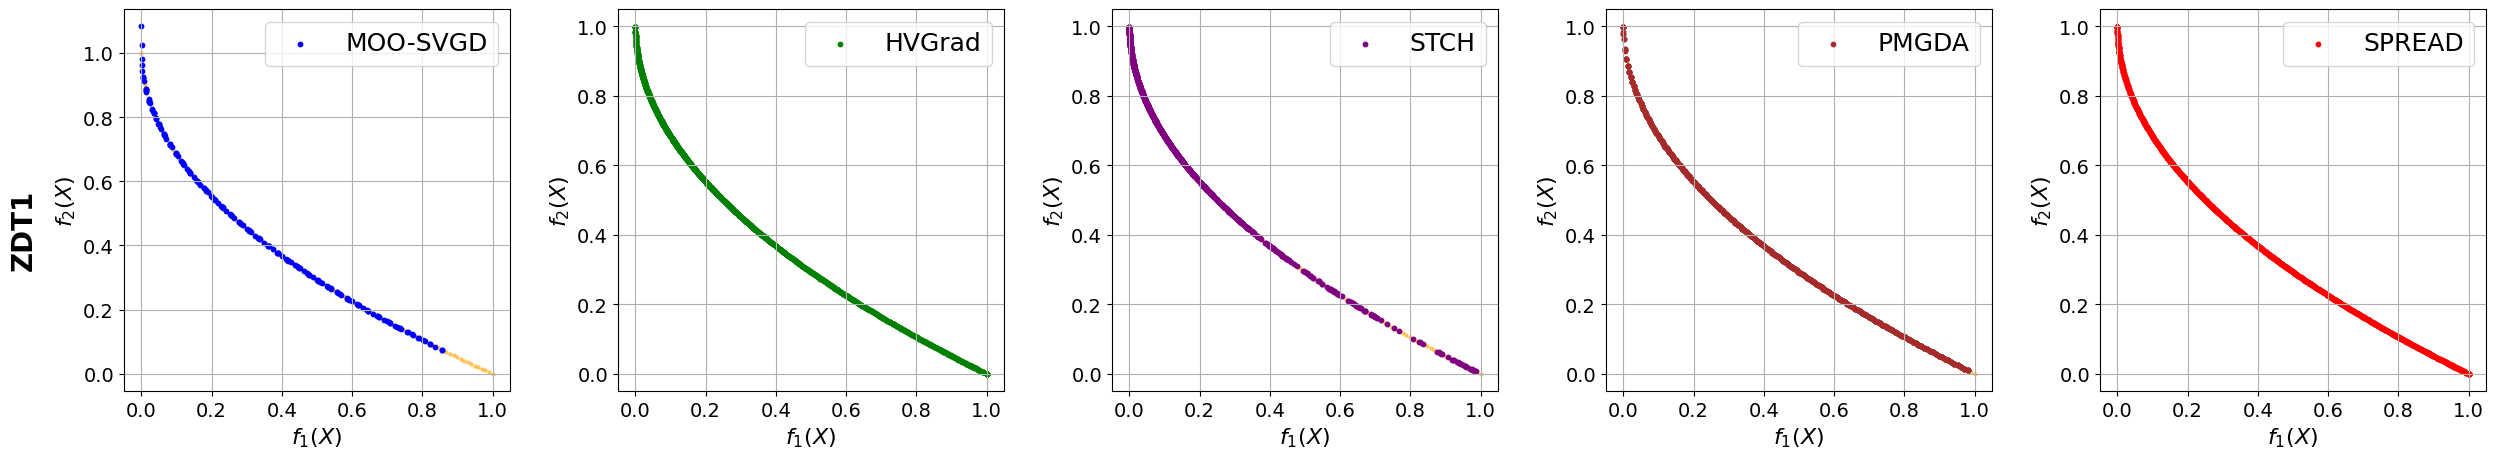

In [15]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="zdt1",
                  alpha_pf=0.5)

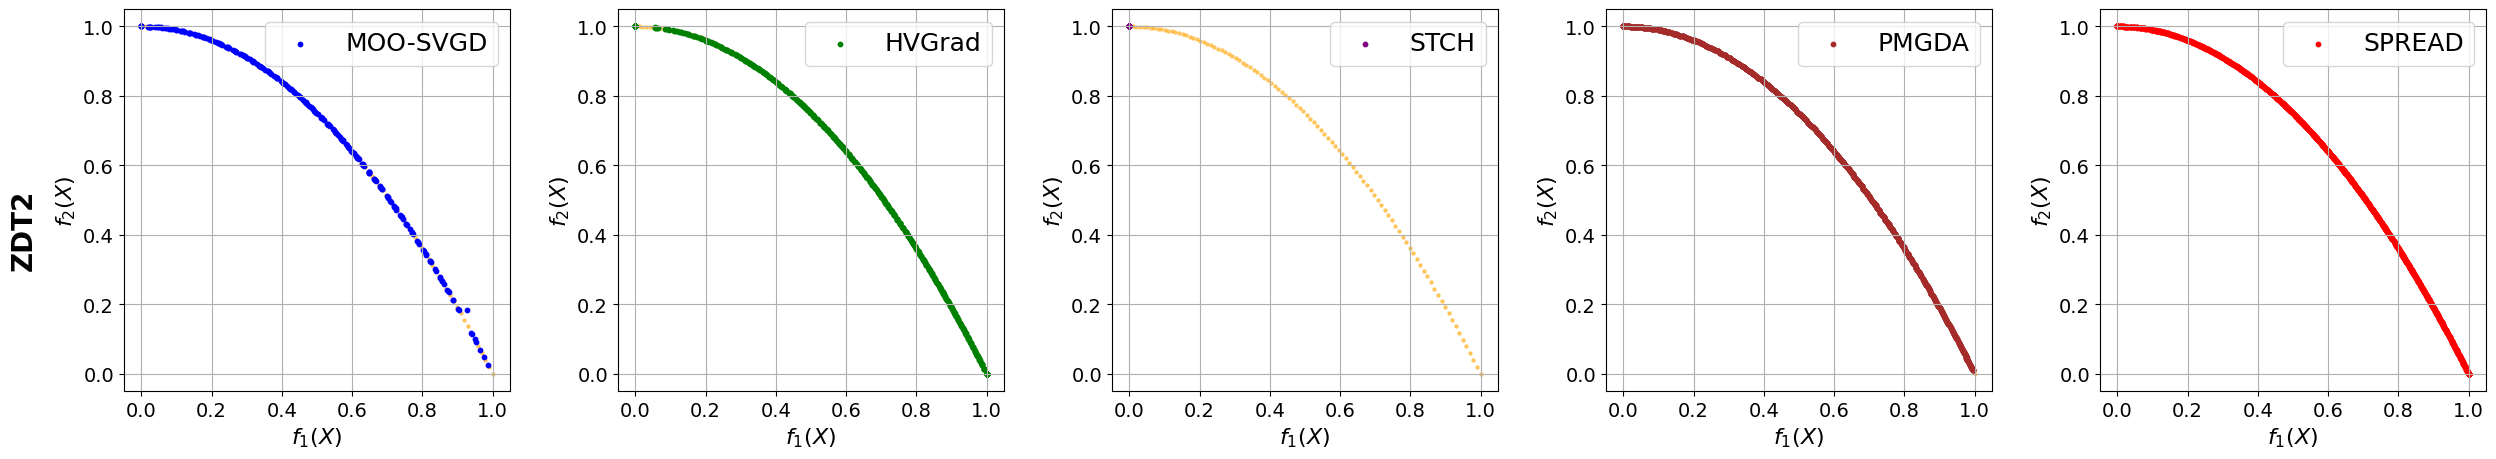

In [16]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="zdt2",
                  alpha_pf=0.5)

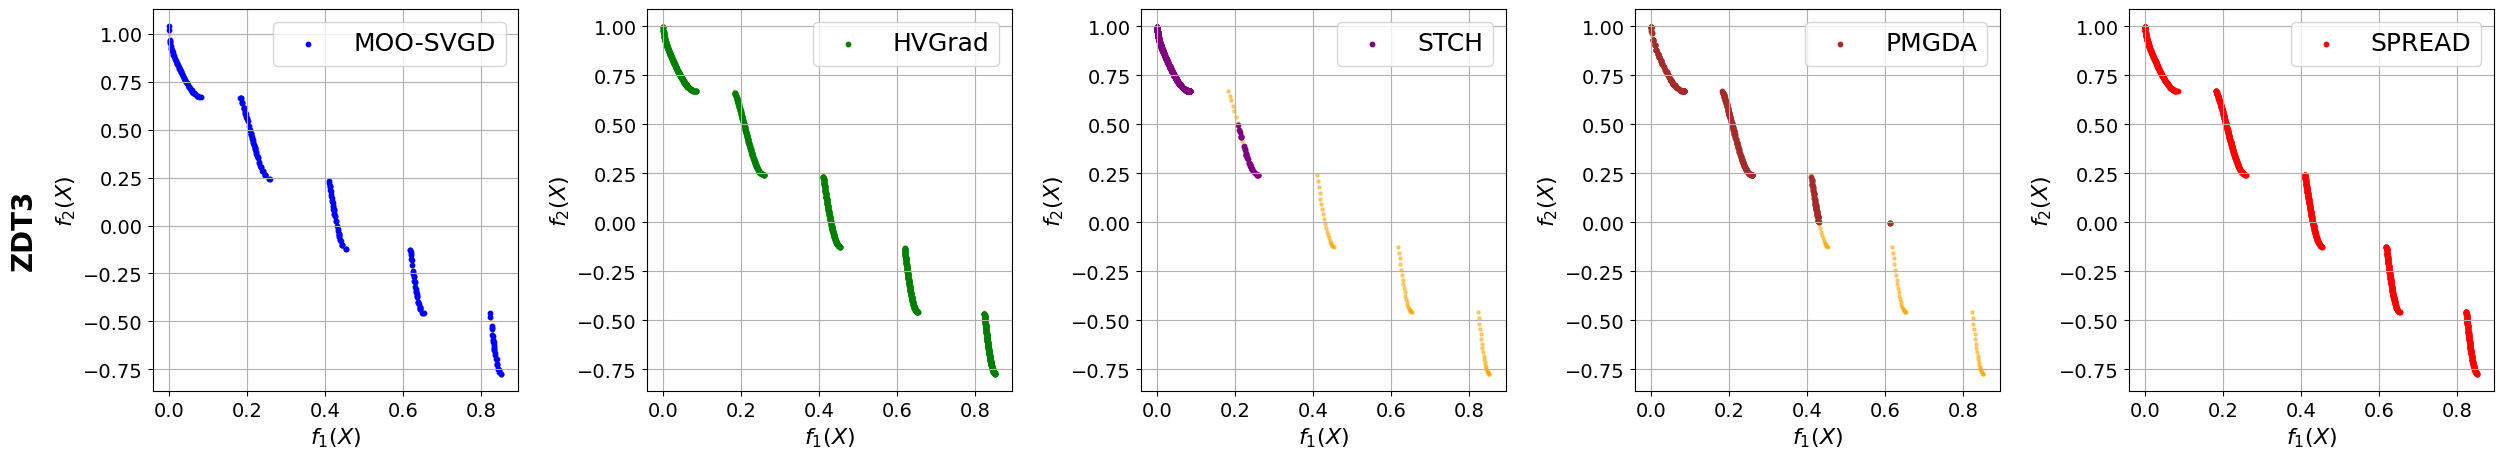

In [17]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="zdt3",
                  alpha_pf=0.5)

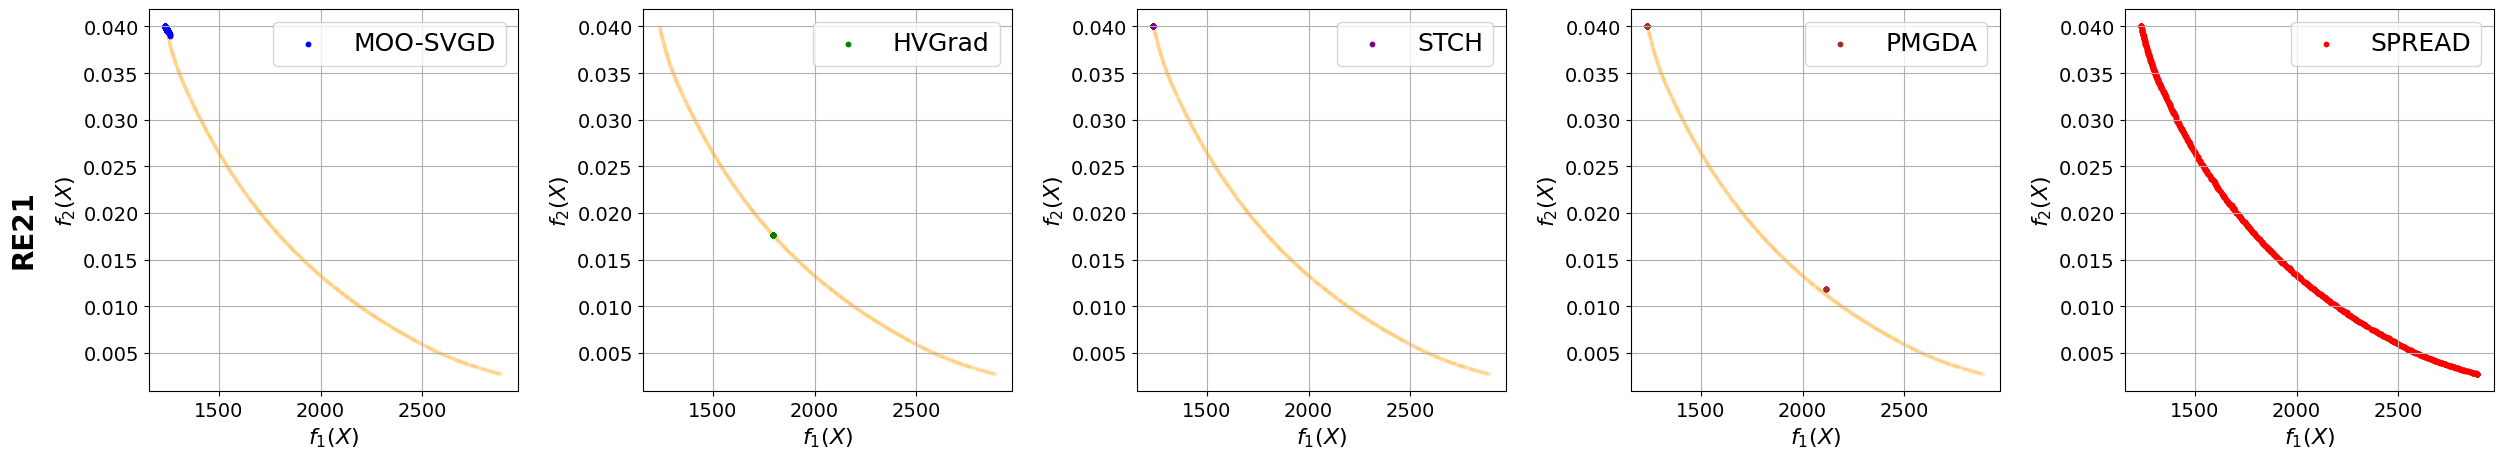

In [18]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="re21",
                  alpha_pf=0.05)

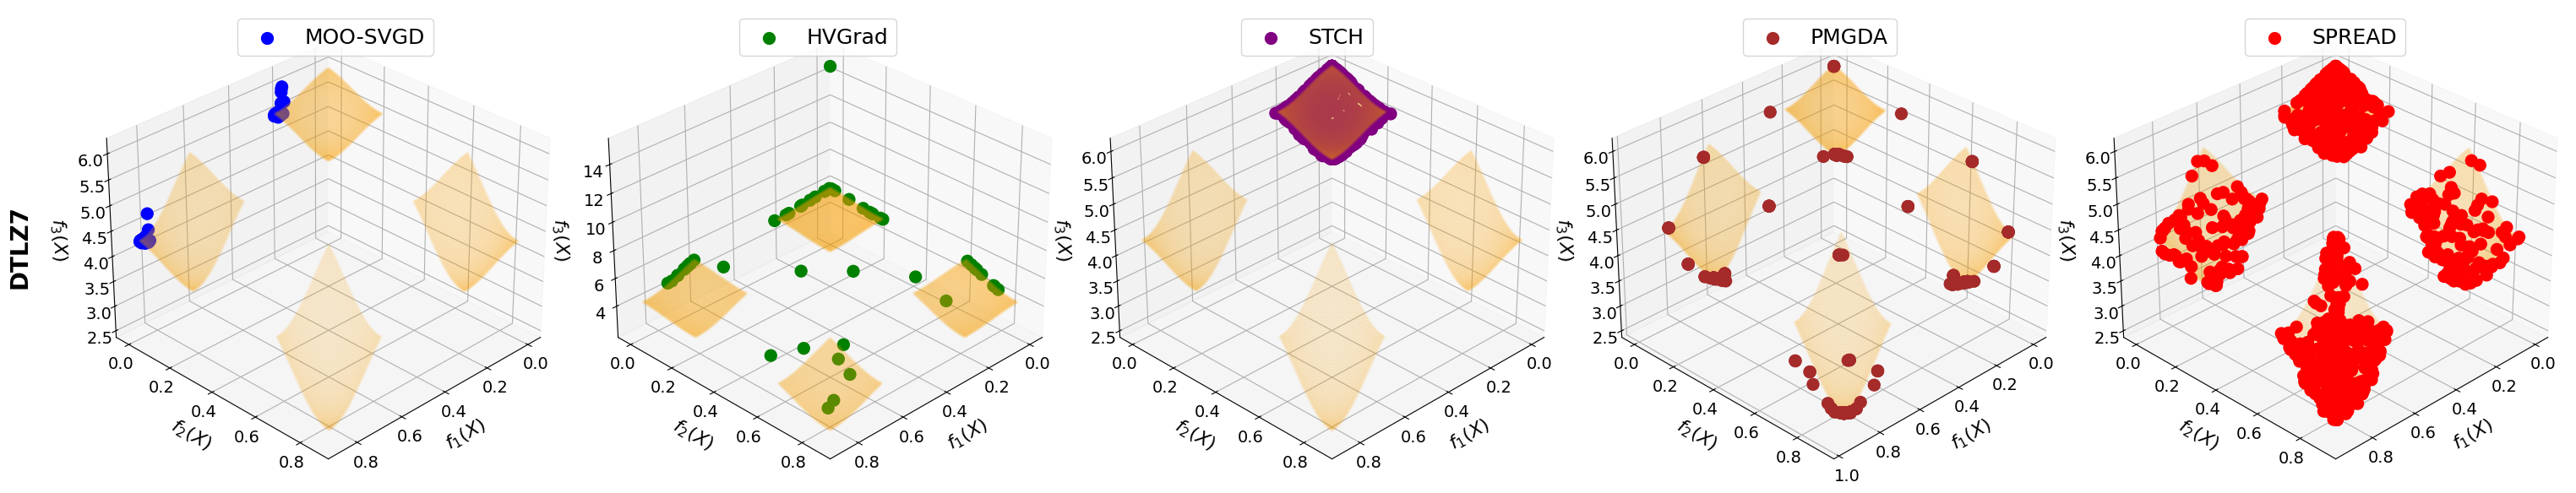

In [21]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="dtlz7",
                  alpha_pf=0.07)

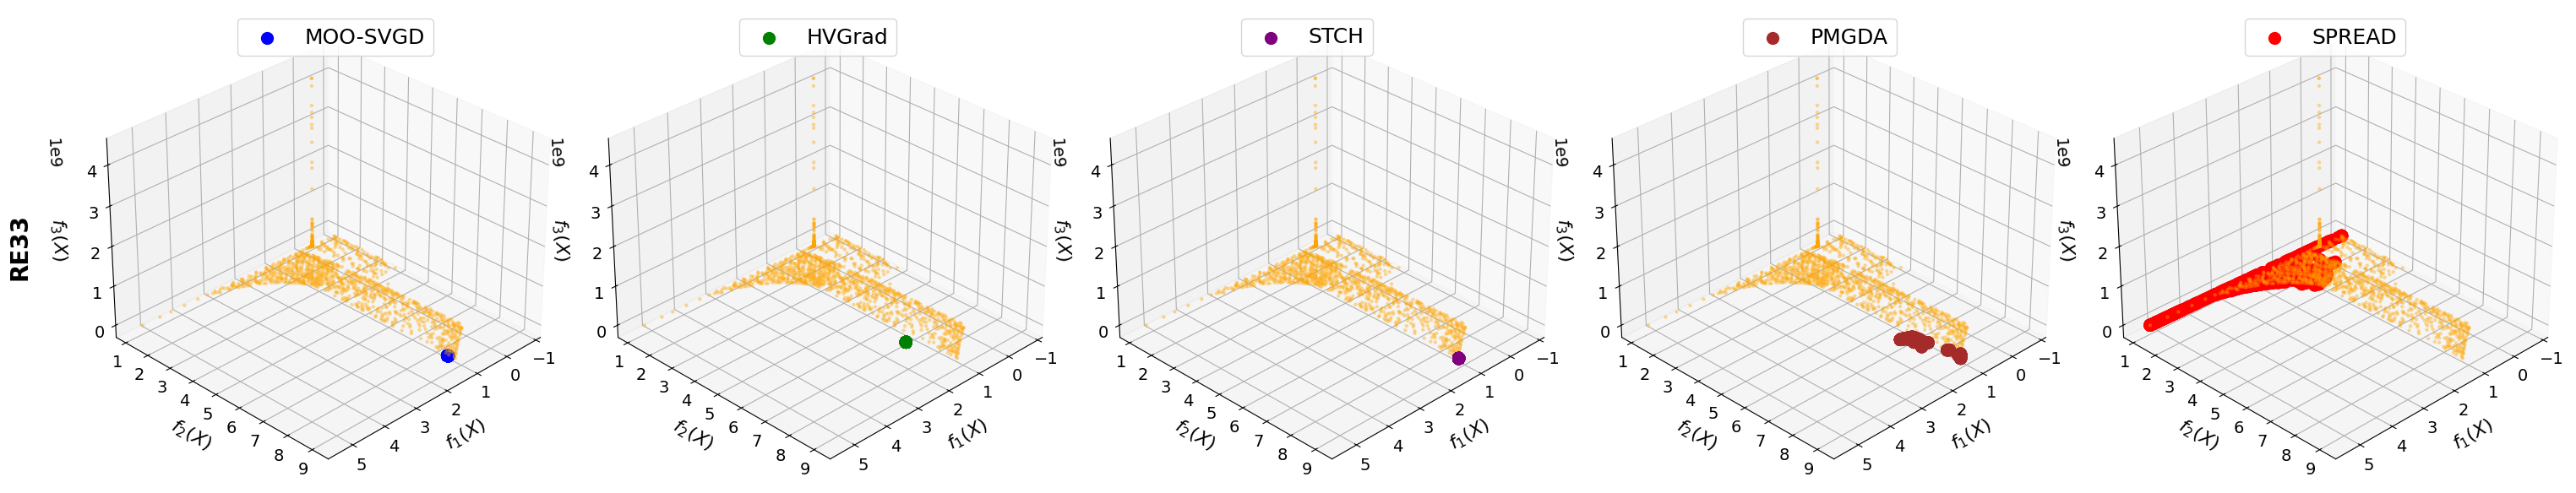

In [19]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="re33",
                  alpha_pf=0.3)

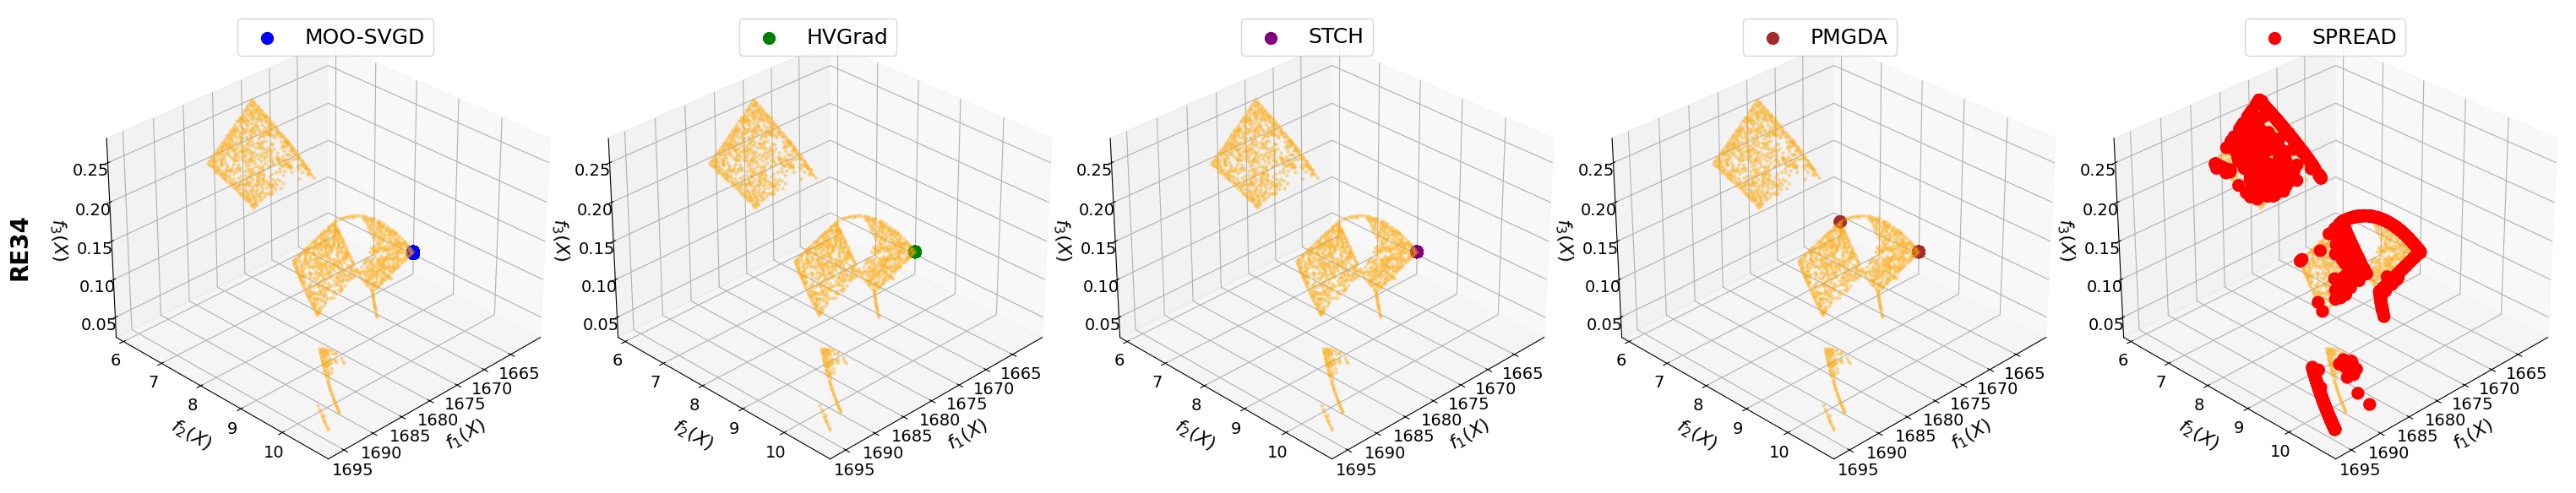

In [22]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="re34",
                  alpha_pf=0.3)

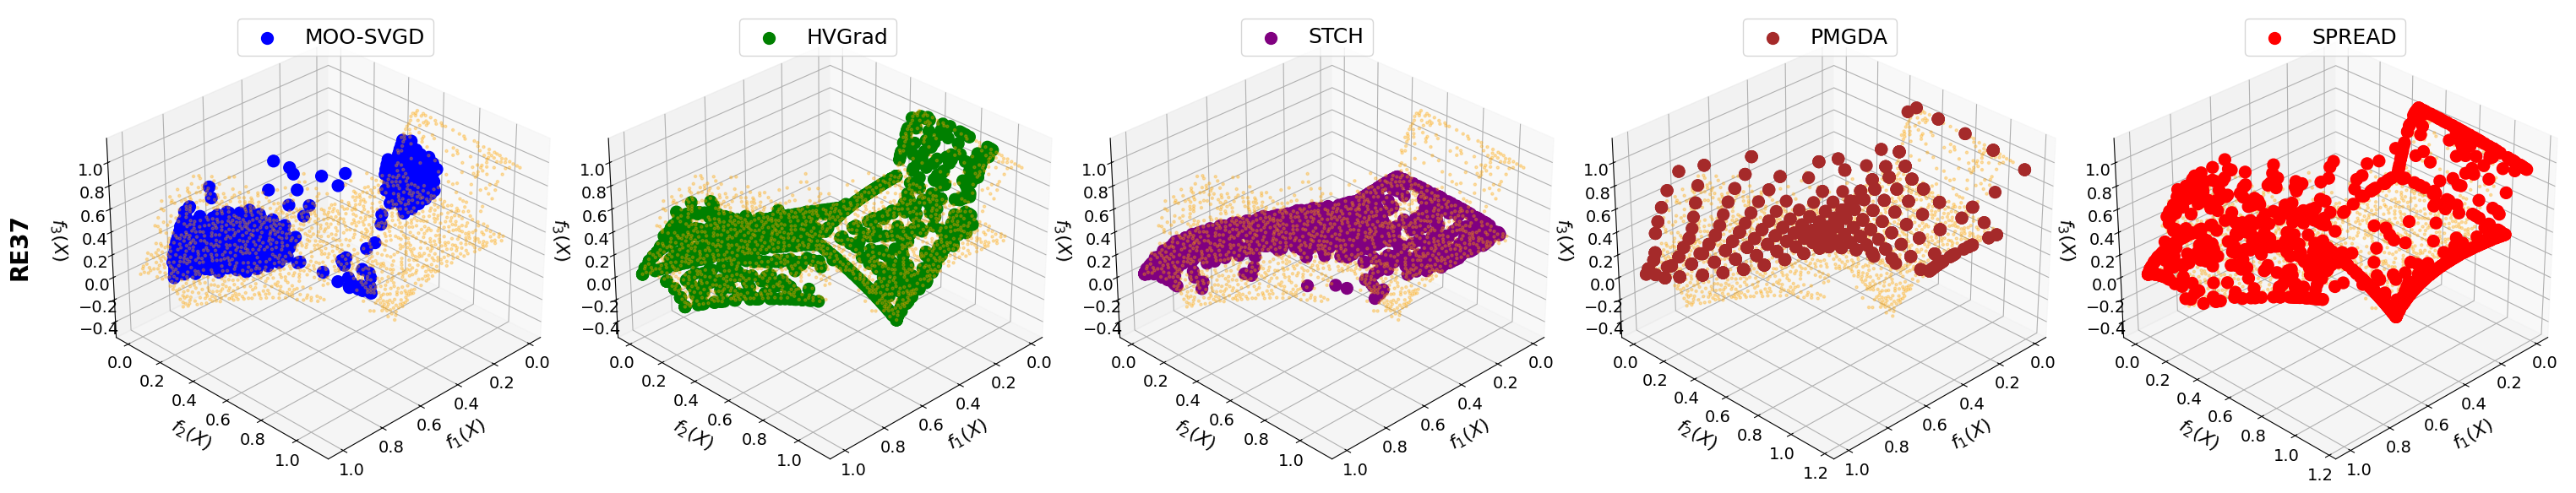

In [23]:
plot_pareto_front(methods=list_methods, 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="re37",
                  alpha_pf=0.3)

# Hypervolume

In [27]:
def compute_mean_std_HV(methods, problems, num_points_sample):

    dic_method_hv = {}
    
    for method in methods:
        for problem in problems:
            
            ref_point = dic_ref_point.get(problem, None)
            if ref_point is None:
                raise ValueError(f"Reference point for problem '{problem}' not found.")
            hv = HV(ref_point=ref_point)

            list_hv = []
            for seed in [1000, 2000, 3000, 4000, 5000]:
                if method == "spread":
                    data_dir = "generated_samples_ms/spread/"
                    timesteps = 5000
                    name_file = (
                        "spread"
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={timesteps}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
                else:
                    data_dir = f"baselines/{method}/generated_samples_ms/{method}/"
                    iters = 5000
                    name_file = (
                        method
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={iters}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
                res_y = np.load(data_dir + name_file + "_y.npy")
                hv_value = hv(res_y)
                list_hv.append(hv_value)
            mean_hv, std_hv = mean_std_stats(list_hv)
            dic_method_hv[(method, problem)] = [mean_hv, std_hv]
            
    return dic_method_hv


In [28]:
dic_method_hv = compute_mean_std_HV(methods=list_methods, 
                          problems=list_problems, 
                          num_points_sample=200)

In [29]:
df2 = pd.Series(dic_method_hv).unstack(level=1)
# Desired columns order
df2 = df2[["zdt1", "zdt2", "zdt3", "re21", "dtlz2", "dtlz4", "dtlz7", "re33", "re34", "re37", "re41"]]
# Arrange rows order
df2 = df2.reindex(index=["pmgda", "moo_svgd","stch", "hvgrad", "spread"] + df2.index[df2.index.isin(["pmgda", "moo_svgd", "stch",  "hvgrad", "spread"]) == False].tolist())
# Rename rows names
df2.index = df2.index.str.replace("pmgda", "PMGDA")
df2.index = df2.index.str.replace("stch", "STCH")
df2.index = df2.index.str.replace("moo_svgd", "MOO-SVGD")
df2.index = df2.index.str.replace("hvgrad", "HVGrad")
df2.index = df2.index.str.replace("spread", "SPREAD(Ours)")

# Set index and columns names
df2.index.name = 'Method'
df2.columns.name = 'Problem'

df2.columns = df2.columns.str.upper()

for j in range(len(df2.columns)):
    for i in range(len(df2.iloc[:, j])):
        tmp = df2.iloc[i, j]
        df2.iloc[i, j] = str(tmp[0].round(2))+"$\pm$"+str(tmp[1].round(2))
# Display the DataFrame
df2

Problem               ZDT1          ZDT2           ZDT3            RE21  \
Method                                                                    
PMGDA         5.72$\pm$0.0  6.22$\pm$0.0   5.85$\pm$0.0   48.14$\pm$0.0   
MOO-SVGD       5.7$\pm$0.0  6.21$\pm$0.0  6.08$\pm$0.02  20.43$\pm$0.32   
STCH          5.71$\pm$0.0  5.89$\pm$0.0  5.44$\pm$0.13   19.07$\pm$0.0   
HVGrad        5.72$\pm$0.0  6.22$\pm$0.0    6.1$\pm$0.0   43.65$\pm$0.0   
SPREAD(Ours)  5.72$\pm$0.0  6.22$\pm$0.0    6.1$\pm$0.0   70.1$\pm$0.01   

Problem                DTLZ2           DTLZ4           DTLZ7             RE33  \
Method                                                                          
PMGDA          22.97$\pm$0.0   19.69$\pm$0.2   17.82$\pm$0.0    43.06$\pm$0.0   
MOO-SVGD      22.61$\pm$0.02  19.69$\pm$0.62  13.57$\pm$0.03   16.26$\pm$0.17   
STCH          22.92$\pm$0.01   14.55$\pm$0.0   17.46$\pm$0.0    12.14$\pm$0.0   
HVGrad         22.93$\pm$0.0  19.98$\pm$0.04  17.48$\pm$0.05    36.13$\pm$0.0   
SPREAD(Ours)   22.91$\pm$0.0  20.22$\pm$0.01  18.07$\pm$0.01  133.76$\pm$1.72   

Problem                  RE34           RE37             RE41  
Method                                                         
PMGDA          210.07$\pm$0.0   1.18$\pm$0.0   901.9$\pm$3.36  
MOO-SVGD       156.2$\pm$0.57  1.05$\pm$0.09  579.53$\pm$6.42  
STCH           156.72$\pm$0.0  1.31$\pm$0.02  506.33$\pm$2.86  
HVGrad         156.72$\pm$0.0   1.44$\pm$0.0  936.17$\pm$8.91  
SPREAD(Ours)  243.15$\pm$0.49   1.42$\pm$0.0  1008.75$\pm$6.3

# Diversity

In [30]:
def compute_DELTA_DIVERSITY(methods, problems, num_points_sample):

    dic_delta_diversity = {}

    print("Computing DELTA DIVERSITY ...")
    for method in methods:
        print("-----------------")
        print(f"Method: {method}")
        for problem in problems:
            pareto_front = get_pareto_front(problem)
            list_diversity = []
            for seed in [1000, 2000, 3000, 4000, 5000]:
                if method == "spread":
                    data_dir = "generated_samples_ms/spread/"
                    timesteps = 5000
                    name_file = (
                        "spread"
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={timesteps}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
                else:
                    data_dir = f"baselines/{method}/generated_samples_ms/{method}/"
                    iters = 5000
                    name_file = (
                        method
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={iters}"
                        + "_"
                        + f"N={num_points_sample}"
                    )

                res_y = np.load(data_dir + name_file + "_y.npy")
                diversity_value = delta_spread(res_y, true_pf=pareto_front)
                list_diversity.append(diversity_value)
            mean_diversity, std_diversity = mean_std_stats(list_diversity)
            dic_delta_diversity[(method, problem)] = [mean_diversity, std_diversity]

    print("-----------------")
    print("Done!")
    return dic_delta_diversity


In [31]:
dic_delta_diversity = compute_DELTA_DIVERSITY(methods=list_methods, 
                          problems=list_problems, 
                          num_points_sample=200)

Computing DELTA DIVERSITY ...
-----------------
Method: moo_svgd
-----------------
Method: hvgrad
-----------------
Method: stch
-----------------
Method: pmgda
-----------------
Method: spread
-----------------
Done!


In [32]:
df3 = pd.Series(dic_delta_diversity).unstack(level=1)
# Desired columns order
df3 = df3[["zdt1", "zdt2", "zdt3", "re21", "dtlz2", "dtlz4", "dtlz7", "re33", "re34", "re37", "re41"]]
# Arrange rows order
df3 = df3.reindex(index=["pmgda", "moo_svgd","stch", "hvgrad", "spread"] + df3.index[df3.index.isin(["pmgda", "moo_svgd", "stch",  "hvgrad", "spread"]) == False].tolist())
# Rename rows names
df3.index = df3.index.str.replace("pmgda", "PMGDA")
df3.index = df3.index.str.replace("stch", "STCH")
df3.index = df3.index.str.replace("moo_svgd", "MOO-SVGD")
df3.index = df3.index.str.replace("hvgrad", "HVGrad")
df3.index = df3.index.str.replace("spread", "SPREAD(Ours)")

# Set index and columns names
df3.index.name = 'Method'
df3.columns.name = 'Problem'

df3.columns = df3.columns.str.upper()

for j in range(len(df3.columns)):
    for i in range(len(df3.iloc[:, j])):
        tmp = df3.iloc[i, j]
        df3.iloc[i, j] = str(tmp[0].round(2))+"$\pm$"+str(tmp[1].round(2))
# Display the DataFrame
df3

Problem                ZDT1           ZDT2           ZDT3           RE21  \
Method                                                                     
PMGDA         0.42$\pm$0.17  0.23$\pm$0.01  1.57$\pm$0.02   1.53$\pm$0.0   
MOO-SVGD       0.78$\pm$0.2  1.16$\pm$0.11   0.9$\pm$0.08   1.01$\pm$0.0   
STCH          1.01$\pm$0.04    1.0$\pm$0.0  1.05$\pm$0.03    1.0$\pm$0.0   
HVGrad        0.36$\pm$0.05  1.07$\pm$0.05   1.08$\pm$0.1    1.0$\pm$0.0   
SPREAD(Ours)  0.32$\pm$0.01  0.29$\pm$0.02  0.53$\pm$0.01  0.44$\pm$0.02   

Problem               DTLZ2          DTLZ4          DTLZ7           RE33  \
Method                                                                     
PMGDA         0.66$\pm$0.02  1.71$\pm$0.07  1.02$\pm$0.08   1.11$\pm$0.0   
MOO-SVGD      1.31$\pm$0.01  1.02$\pm$0.09  0.71$\pm$0.03    1.0$\pm$0.0   
STCH           1.0$\pm$0.04    1.0$\pm$0.0  1.06$\pm$0.05    1.0$\pm$0.0   
HVGrad        1.18$\pm$0.05  1.56$\pm$0.06  0.66$\pm$0.03    1.0$\pm$0.0   
SPREAD(Ours)  0.93$\pm$0.05   0.8$\pm$0.06  0.69$\pm$0.05  0.97$\pm$0.02   

Problem                RE34           RE37           RE41  
Method                                                     
PMGDA          1.46$\pm$0.0  0.59$\pm$0.01  1.46$\pm$0.01  
MOO-SVGD       1.2$\pm$0.17  0.58$\pm$0.07  1.13$\pm$0.04  
STCH            1.0$\pm$0.0   0.8$\pm$0.04  1.38$\pm$0.02  
HVGrad          1.0$\pm$0.0  0.51$\pm$0.01   1.0$\pm$0.02  
SPREAD(Ours)  0.88$\pm$0.03   0.8$\pm$0.01  0.92$\pm$0.03

# Scalability Analysis

In [33]:
from matplotlib.ticker import FuncFormatter

move_y = 10.0 # make lower values visible

def shifted_ticks(y, pos):
    val = y - move_y # remove what was added and show the real coordinates
    return f"{val:.2f}" if val >= 0 else ""   # hide negatives

def ablation_time_objSpaceDim(list_problems, list_methods, colors=None):

    seed = 1000
    timesteps = 5000
    num_points_sample=200
    
    dict_time = {}

    for method in list_methods:
        list_time = []
        for problem in list_problems:
            name = (
                method
                + "_"
                + problem
                + "_"
                + str(seed)
                + "_"
                + f"T={timesteps}"
                + "_"
                + f"N={num_points_sample}"
            )
            
            if "spread" in method:
                res_dir = f"saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
                model_dir = f"log_ms/{method}/saved_{problem}_T{timesteps}_B500" 
                TRAIN_FILE = str("%s/train_infos.pth" % (model_dir))
                TRAIN_FILE = torch.load(TRAIN_FILE, weights_only=False)
            else:
                res_dir = f"baselines/{method}/saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
            
            with open(res_dir, "rb") as f:
                hv_results = pickle.load(f)
            total_time = hv_results.get("computation_time", None)
            if "spread" in method:
                total_time = total_time + TRAIN_FILE.get("train_time", None)
            assert total_time is not None, f"Time was not saved for method {method} on problem {problem} !"
            total_time = total_time / 60 # convert to minutes
            list_time.append(total_time + move_y) # make lower values visible
        dict_time[method] = list_time

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(list_problems))
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(list_methods)

    for i, (method, times) in enumerate(dict_time.items()):
        if "spread" in method:
            lab = "SPREAD (Ours)"
        elif "hvgrad" in method:
            lab = "HVGrad"
        elif "svgd" in method:
            lab = "MOO-SVGD"
        else:
            lab = method.upper()

        n_methods = len(list_methods)          # number of methods
        bar_width = 0.8 / n_methods         # width of each bar (fit nicely inside one slot)
        offset = (i - n_methods/2) * bar_width + bar_width/2
        ax.bar(x + offset, times, width=bar_width, label=lab, color=colors[i])
  
    ax.set_ylabel("Time (minutes)", fontsize=25)
    h, l = ax.get_legend_handles_labels()
    fig.legend(
            h,
            l,
            loc="right",
            ncol=1,
            bbox_to_anchor=(0.53, 0.66),
            fontsize=25
        )
    ax.set_xticks(x)
    xlabels = ["ZDT1($m=2$)", "DTLZ2($m=3$)", "RE41($m=4$)"]
    ax.set_xticklabels(xlabels)
    ax.yaxis.set_major_formatter(FuncFormatter(shifted_ticks))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    for label in ax.get_yticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')  # center around the tick
        label.set_verticalalignment('center')
        label.set_x(-0.01)
        
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        f"plots/exp_stand_time.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_time.pdf", format="pdf", bbox_inches="tight")
    plt.show()

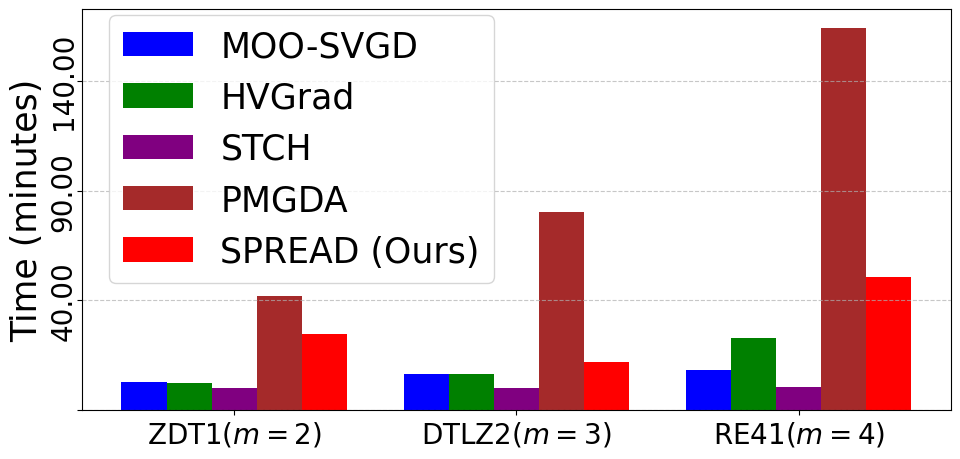

In [34]:
ablation_time_objSpaceDim(list_problems=["zdt1", "dtlz2", "re41"], 
              list_methods=["moo_svgd", "hvgrad", "stch", "pmgda", 
                            "spread_ablation_time"
                            ], 
              colors = colors)

In [35]:
def ablation_time_sampleSize(list_methods, list_num_samples,
                             problem="dtlz4", colors=None, 
                             plot_data="time"):

    seed = 1000
    timesteps = 5000

    dict_data = {}

    for method in list_methods:
        list_data = []
        for nsample in list_num_samples:
            name = (
                method
                + "_"
                + problem
                + "_"
                + str(seed)
                + "_"
                + f"T={timesteps}"
                + "_"
                + f"N={nsample}"
            )
            
            if "spread" in method:
                res_dir = f"saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
                model_dir = f"log_ms/{method}/saved_{problem}_T{timesteps}_B500" 
                TRAIN_FILE = str("%s/train_infos.pth" % (model_dir))
                TRAIN_FILE = torch.load(TRAIN_FILE, weights_only=False)
                data_dir = f"generated_samples_ms/{method}/"
            else:
                res_dir = f"baselines/{method}/saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
                data_dir = f"baselines/{method}/generated_samples_ms/{method}/"
            
            with open(res_dir, "rb") as f:
                hv_results = pickle.load(f)
            
            if "time" in plot_data:
                plt_data = "computation_time"
            elif "hv" in plot_data:
                plt_data = "hypervolume"
            elif "diversity" in plot_data:
                plt_data = "diversity"
            else:
                raise ValueError(f"Unknown plot_data: {plot_data}")

            if ("time" in plot_data) or ("hv" in plot_data):
                total_data = hv_results.get(plt_data, None)
                assert total_data is not None, f"{plt_data} was not saved for method {method} on problem {problem} !"
            else:
                res_y = np.load(data_dir + name + "_y.npy")
                pareto_front = get_pareto_front(problem)
                total_data = delta_spread(res_y, true_pf=pareto_front)
                
            if "time" in plot_data:
                if "spread" in method:
                    total_data = total_data + TRAIN_FILE.get("train_time", None)
                total_data = total_data / 60 # convert to minutes
                list_data.append(total_data)
            else:
                list_data.append(total_data)
        dict_data[method] = list_data

    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(list_num_samples))
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(list_methods)
        
    if not "diversity" in plot_data:
        # Create inset axis
        axins = inset_axes(
                ax,
                width="35%",          # size relative to main axes (ensure < 100%)
                height="35%",
                loc="center right",    # anchor corner inside the main axes
                borderpad=1.0         # padding from the edges
            )

    for i, (method, data) in enumerate(dict_data.items()):
        if "spread" in method:
            lab = "SPREAD (Ours)"
        elif "hvgrad" in method:
            lab = "HVGrad"
        elif "svgd" in method:
            lab = "MOO-SVGD"
        else:
            lab = method.upper()

        ax.plot(x, data, 
                linestyle='-', color=colors[i], 
                label=lab, linewidth=5) 
        ax.scatter(x, data, s=45, color=colors[i])
        
        if not "diversity" in plot_data:
            axins.plot(x, data, linestyle='-', color=colors[i], linewidth=5)
            axins.scatter(x, data, s=45, color=colors[i])

            
    if "time" in plot_data:
        ax.set_ylabel("Time (minutes)", fontsize=25)
    elif "hv" in plot_data:
        ax.set_ylabel("HV", fontsize=25)
    else:
        ax.set_ylabel("$\Delta$-spread", fontsize=25)
    ax.set_xlabel("$n$", fontsize=25)

    ax.set_xticks(x)
    xlabels = [f"${n}$" for n in list_num_samples]
    ax.set_xticklabels(xlabels)
    ax.set_xlim(-0.4, len(xlabels) - 0.4)
    
    if not "diversity" in plot_data:
        if "time" not in plot_data:
            # Set zoom region
            axins.set_xlim(-0.2, 3.2)
            axins.set_ylim(19.7, 20.4)
        else:
            axins.set_xlim(-0.2, 3.2)
            axins.set_ylim(1, 26.0)
            
        axins.tick_params(axis='x', which='both',
                        labelbottom=False, labelleft=False,  # hide labels
                        bottom=False, left=False)   
            
        for spine in axins.spines.values():
            spine.set_linewidth(0.8)
                
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", linestyle="--", linewidth=0.8)
            
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    for label in ax.get_yticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')  # center around the tick
        label.set_verticalalignment('center')
        label.set_x(-0.02)
    
    ax.grid()
    plt.tight_layout()
    plt.savefig(
        f"plots/exp_stand_{plot_data}_sample.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_{plot_data}_sample.pdf", format="pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_471905/2254000267.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


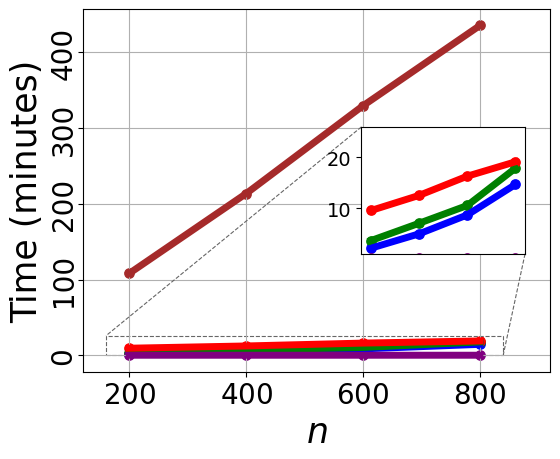

In [36]:
ablation_time_sampleSize(list_methods=[
                                    "moo_svgd", 
                                       "hvgrad", 
                                       "stch", 
                                       "pmgda", 
                                       "spread_ablation_time"
                                       ], 
              list_num_samples = [200, 400, 600, 800],
              problem="dtlz4",
              colors = colors, plot_data="time")

/tmp/ipykernel_471905/2254000267.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


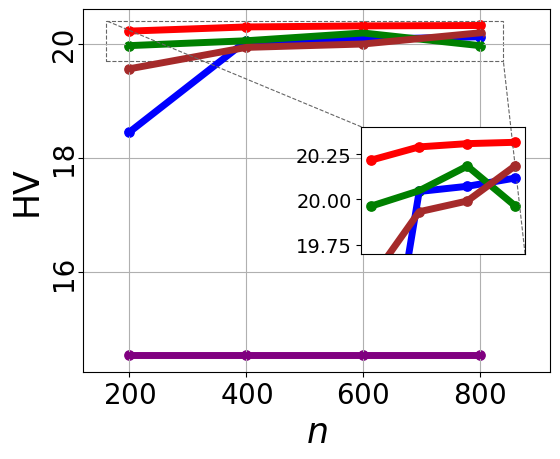

In [37]:
ablation_time_sampleSize(list_methods=[
                                    "moo_svgd", 
                                       "hvgrad", 
                                       "stch", 
                                       "pmgda", 
                                       "spread_ablation_time"
                                       ], 
              list_num_samples = [200, 400, 600, 800],
              problem="dtlz4",
              colors = colors, plot_data="hv")

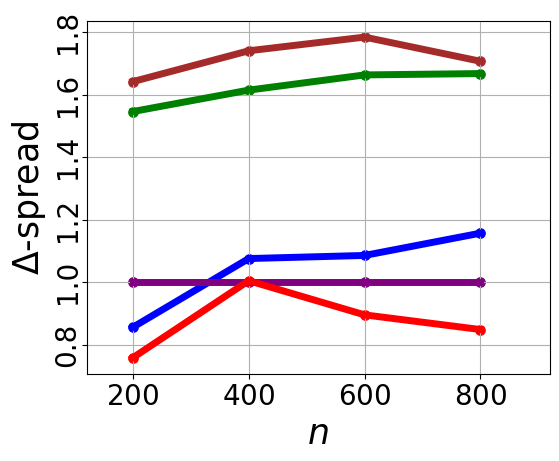

In [38]:
ablation_time_sampleSize(list_methods=[
                                    "moo_svgd", 
                                       "hvgrad", 
                                       "stch", 
                                       "pmgda", 
                                       "spread_ablation_time"
                                       ], 
              list_num_samples = [200, 400, 600, 800],
              problem="dtlz4",
              colors = colors, plot_data="diversity")

# Ablation Study

In [39]:
def ablation_spread_diversity(methods, seeds, num_points_sample, 
                      colors= None, problem="dtlz7", alpha_pf=0.07):
    
    if problem.startswith("zdt"):
        problem_torch = get_problem_torch(problem, n_var=30)
    elif problem.startswith("dtlz"):
        problem_torch = get_problem_torch(problem, n_var=30, n_obj=3)
    else:
        try:
            problem_torch = get_problem_torch(problem)
        except ValueError:
            raise ValueError(f"Unknown problem: {problem}")
    n_obj = problem_torch.n_obj
    
    if n_obj == 3:
        fig, axes = plt.subplots(1, len(methods), figsize=(7*len(methods), 8),
                         subplot_kw={'projection': '3d'})
    elif n_obj == 2:
        fig, axes = plt.subplots(1, len(methods), figsize=(7*len(methods), 8))
    else:
        raise ValueError(f"Unsupported number of objectives: {n_obj}. Only 2 or 3 are supported.")
    if len(methods) == 1:
        axes = [axes]
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(methods)
    count = 0
    for ax, method, color in zip(axes, methods, colors):
        if method == "spread":
            color = "red"
        all_res_y = None
        list_hv = []
        list_delta =  []
        for seed in seeds:
            data_dir = f"generated_samples_ms/{method}/"
            timesteps = 5000
            name_file = (
                        method
                        + "_"
                        + problem
                        + "_"
                        + str(seed)
                        + "_"
                        + f"T={timesteps}"
                        + "_"
                        + f"N={num_points_sample}"
                    )
            res_y = np.load(data_dir + name_file + "_y.npy")
            pareto_front = get_pareto_front(problem)
            total_data = delta_spread(res_y, true_pf=pareto_front)
            list_delta.append(total_data)
            
            res_dir = f"saved_metrics_ms/{method}/" + name_file + "_hv_results.pkl"
            with open(res_dir, "rb") as f:
                hv_results = pickle.load(f)
            total_data = hv_results.get("hypervolume", None)
            list_hv.append(total_data)
                
            if all_res_y is None:
                all_res_y = res_y
            else:
                all_res_y = np.concatenate((all_res_y, res_y), axis=0)
 
        nd_idx = get_non_dominated_points(points_pred = None, 
                                    problem=None,
                                    keep_shape=False, 
                                    indx_only=True, 
                                    p_front = all_res_y )
        res_y = all_res_y[nd_idx]

        mean_hv, std_hv = mean_std_stats(list_hv)
        mean_delta, std_delta = mean_std_stats(list_delta)
        if np.isnan(mean_delta) or np.isnan(std_delta):
            mean_delta, std_delta = "$+\infty$", "$+\infty$"

        if "diversity" in method:
            if mean_delta != "$+\infty$":
                label = (rf"$\mathbf{{SPREAD\ (w/o\ diversity)}}$"\
                        "\n"\
                        f"$\Delta$-spread: {mean_delta:.2f}$\pm${std_delta:.2f}\n"\
                        f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
            else:
                label = (rf"$\mathbf{{SPREAD\ (w/o\ diversity)}}$"\
                        "\n"\
                        f"$\Delta$-spread: {mean_delta}\n"\
                        f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
        elif "repulsion" in method:
            if mean_delta != "$+\infty$":
                label = (rf"$\mathbf{{SPREAD\ (w/o\ repulsion)}}$"\
                    "\n"\
                        f"$\Delta$-spread: {mean_delta:.2f}$\pm${std_delta:.2f}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
            else:
                label = (rf"$\mathbf{{SPREAD\ (w/o\ repulsion)}}$"\
                    "\n"\
                    f"$\Delta$-spread: {mean_delta}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")

        elif "noise" in method:
            if mean_delta != "$+\infty$":
                label = (rf"$\mathbf{{SPREAD\ (w/o\ perturbation)}}$"\
                    "\n"\
                    f"$\Delta$-spread: {mean_delta:.2f}$\pm${std_delta:.2f}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
            else:
                label = (rf"$\mathbf{{SPREAD\ (w/o\ perturbation)}}$"\
                    "\n"\
                    f"$\Delta$-spread: {mean_delta}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
        else:
            if mean_delta != "$+\infty$":
                label = (rf"$\mathbf{{SPREAD}}$"\
                    "\n"\
                    f"$\Delta$-spread: {mean_delta:.2f}$\pm${std_delta:.2f}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")
            else:
                label = (rf"$\mathbf{{SPREAD}}$"\
                    "\n"\
                    f"$\Delta$-spread: {mean_delta}\n"\
                    f"HV: {mean_hv:.2f}$\pm${std_hv:.2f}")

        if n_obj == 3:
            
            X = res_y[:,0]
            Y = res_y[:,1]
            Z = res_y[:,2]  
            
            ax.scatter(problem_torch.pareto_front()[:, 0], 
                       problem_torch.pareto_front()[:, 1], 
                       problem_torch.pareto_front()[:, 2],
                        s=5, alpha=alpha_pf,
                        color='orange')
            ax.scatter(X, Y, Z,
                        s=100,
                        alpha=1.0,
                        color=color, label=label)
            
            ax.set_xlabel("$f_1(X)$", labelpad=5)
            ax.set_ylabel("$f_2(X)$", labelpad=5)
            ax.set_zlabel("$f_3(X)$", labelpad=5)
            if not method == "spread":
                ax.legend(loc='upper left',
                        bbox_to_anchor=(-0.2, 1.25),
                        fontsize=25
                        )
            else:
                ax.legend(loc='upper left',
                        bbox_to_anchor=(-0.1, 1.25),
                        fontsize=25
                        )
            ax.view_init(elev=30, azim=45)
            ax.tick_params(axis='x', pad=0)
            ax.tick_params(axis='y', pad=0)
            ax.tick_params(axis='z', pad=0)
            count += 1
        elif n_obj == 2:
            ax.scatter(problem_torch.pareto_front()[:, 0], 
                       problem_torch.pareto_front()[:, 1], 
                        s=5, alpha=alpha_pf,
                        color='orange')
            ax.scatter(res_y[:, 0], res_y[:, 1],
                       s=50, alpha=1.0, 
                       color=color, label=label)
            ax.set_xlabel("$f_1(X)$")
            ax.set_ylabel("$f_2(X)$")

            if not method == "spread":
                ax.legend(loc='upper left',
                        bbox_to_anchor=(-0.2, 1.5),
                        fontsize=25
                        )
            else:
                ax.legend(loc='upper left',
                        bbox_to_anchor=(-0.1, 1.5),
                        fontsize=25
                        )
        ax.grid(True)
        
    fig.subplots_adjust(left=0.2)
    plt.tight_layout()
    if n_obj == 2:
        fig.text(0.0, 0.5, problem.upper(),
            va='center', ha='center',
            rotation='vertical',
            fontsize=20, fontweight='bold')
    else:
        fig.text(0.0, 0.5, problem.upper(),
            va='center', ha='center',
            rotation='vertical',
            fontsize=20, fontweight='bold')
    plt.savefig(
        f"plots/exp_stand_ablaDIver_{problem}.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_ablaDiver_{problem}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

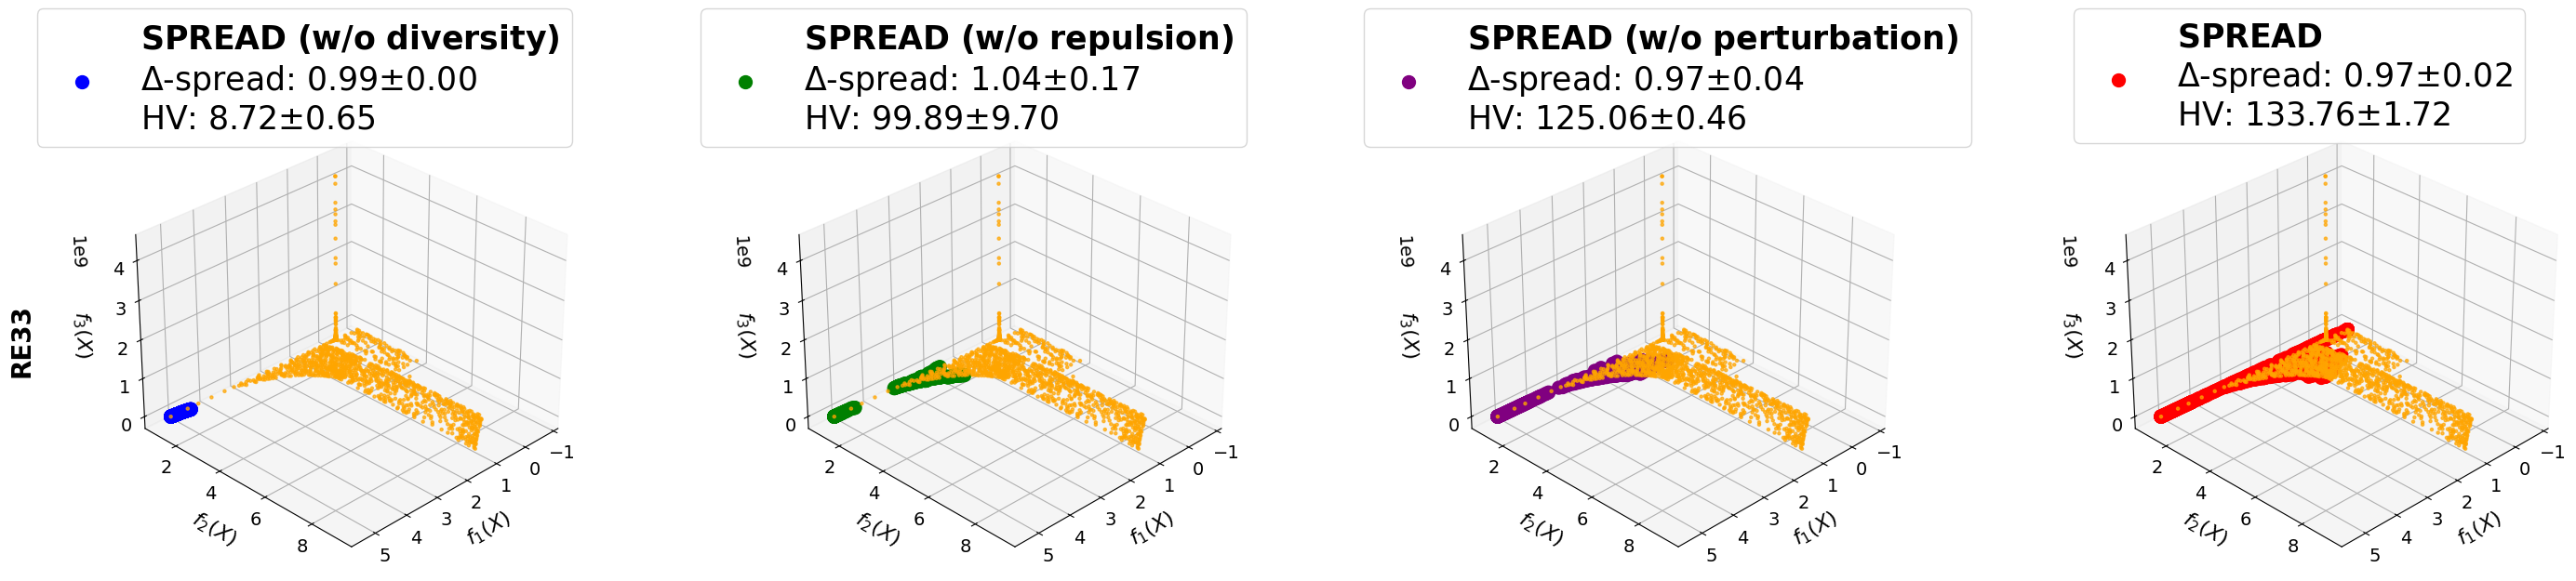

In [40]:
ablation_spread_diversity(methods=[
    "spread_ablation_diversity", 
                                   "spread_ablation_repulsion",
                                   "spread_ablation_noise", 
                                   "spread"], 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="re33",
                  alpha_pf=0.7)

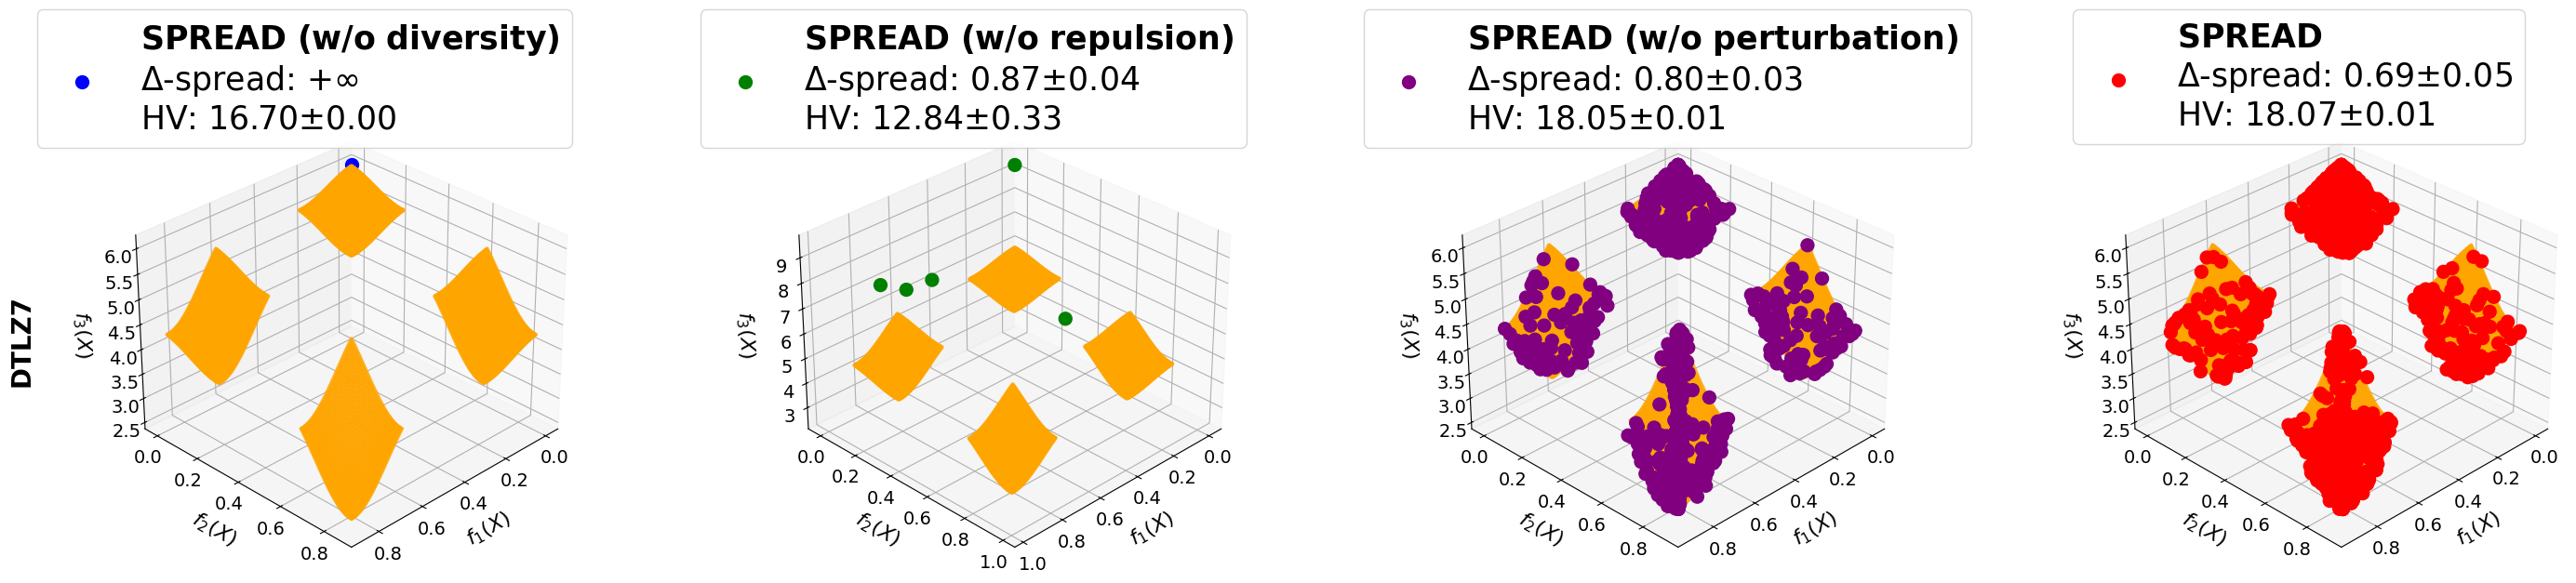

In [46]:
ablation_spread_diversity(methods=[
    "spread_ablation_diversity", 
                                   "spread_ablation_repulsion",
                                   "spread_ablation_noise", 
                                   "spread"], 
                  seeds=[1000, 2000, 3000, 4000, 5000], 
                  num_points_sample=200,
                  colors=colors,
                  problem="dtlz7",
                  alpha_pf=0.7)

In [47]:
def table_ablation_spread_diversity(methods, seeds, 
                                    num_points_sample, problems):
    
    dict_spread_diversity = {}
    dict_spread_hv = {}
    for problem in problems:
        print(f"Problem: {problem}")
        for method in methods:
            all_res_y = None
            list_hv = []
            list_delta =  []
            for seed in seeds:
                data_dir = f"generated_samples_ms/{method}/"
                timesteps = 5000
                name_file = (
                            method
                            + "_"
                            + problem
                            + "_"
                            + str(seed)
                            + "_"
                            + f"T={timesteps}"
                            + "_"
                            + f"N={num_points_sample}"
                        )
                res_y = np.load(data_dir + name_file + "_y.npy")
                pareto_front = get_pareto_front(problem)
                total_data = delta_spread(res_y, true_pf=pareto_front)
                list_delta.append(total_data)
                
                res_dir = f"saved_metrics_ms/{method}/" + name_file + "_hv_results.pkl"
                with open(res_dir, "rb") as f:
                    hv_results = pickle.load(f)
                total_data = hv_results.get("hypervolume", None)
                list_hv.append(total_data)
                    
                if all_res_y is None:
                    all_res_y = res_y
                else:
                    all_res_y = np.concatenate((all_res_y, res_y), axis=0)
    
            nd_idx = get_non_dominated_points(points_pred = None, 
                                        problem=None,
                                        keep_shape=False, 
                                        indx_only=True, 
                                        p_front = all_res_y )
            res_y = all_res_y[nd_idx]

            mean_hv, std_hv = mean_std_stats(list_hv)
            mean_delta, std_delta = mean_std_stats(list_delta)
            if np.isnan(mean_delta) or np.isnan(std_delta):
                mean_delta, std_delta = "$+\infty$", "$+\infty$"
                
            if "diversity" in method:
                label = "SPREAD (w/o diversity)"
            elif "repulsion" in method:
                label = "SPREAD (w/o repulsion)"
            elif "noise" in method:
                label = "SPREAD (w/o perturbation)"
            else:
                label = "SPREAD"
                
            if mean_delta == "$+\infty$":
                dict_spread_diversity[(label, problem)] = [mean_delta, std_delta]
            else:
                dict_spread_diversity[(label, problem)] = [mean_delta.round(2), std_delta.round(2)]
                
            dict_spread_hv[(label, problem)] = [mean_hv.round(2), std_hv.round(2)]
            
    return dict_spread_diversity, dict_spread_hv


In [48]:
dict_spread_diversity, dict_spread_hv = table_ablation_spread_diversity(methods=["spread_ablation_diversity", 
                                   "spread_ablation_repulsion",
                                   "spread_ablation_noise", 
                                   "spread"], 
                                seeds=[1000, 2000, 3000, 4000, 5000], 
                                 num_points_sample=200, 
                                problems=["zdt1", "zdt2", "zdt3", "re21", 
                                          "dtlz2", "dtlz4", "dtlz7", 
                                          "re33", "re34", "re37", "re41"])

Problem: zdt1
Problem: zdt2
Problem: zdt3
Problem: re21
Problem: dtlz2
Problem: dtlz4
Problem: dtlz7
Problem: re33
Problem: re34
Problem: re37
Problem: re41


In [49]:
data = dict_spread_hv
df3 = pd.Series(data
                ).unstack(level=1)

df3 = df3[["zdt1", "zdt2", "zdt3", "re21", "dtlz2", "dtlz4", "dtlz7", "re33", "re34", "re37", "re41"]]
# Set index and columns names
df3.index.name = 'Method'
df3.columns.name = 'Problem'

df3.columns = df3.columns.str.upper()

for j in range(len(df3.columns)):
    for i in range(len(df3.iloc[:, j])):
        tmp = df3.iloc[i, j]
        df3.iloc[i, j] = str(tmp[0])+"$\pm$"+str(tmp[1])
# Display the DataFrame
df3

Problem                             ZDT1          ZDT2           ZDT3  \
Method                                                                  
SPREAD                      5.72$\pm$0.0  6.22$\pm$0.0    6.1$\pm$0.0   
SPREAD (w/o diversity)      5.06$\pm$0.0  5.89$\pm$0.0   5.06$\pm$0.0   
SPREAD (w/o perturbation)   5.72$\pm$0.0  6.22$\pm$0.0    6.1$\pm$0.0   
SPREAD (w/o repulsion)     4.25$\pm$0.08  4.4$\pm$0.14  4.34$\pm$0.07   

Problem                              RE21           DTLZ2           DTLZ4  \
Method                                                                      
SPREAD                      70.1$\pm$0.01   22.91$\pm$0.0  20.22$\pm$0.01   
SPREAD (w/o diversity)     70.03$\pm$0.01   22.94$\pm$0.0  20.36$\pm$0.01   
SPREAD (w/o perturbation)  69.01$\pm$0.14   22.8$\pm$0.01  20.01$\pm$0.02   
SPREAD (w/o repulsion)     70.03$\pm$0.03  22.79$\pm$0.04  20.34$\pm$0.02   

Problem                             DTLZ7             RE33             RE34  \
Method                                                                        
SPREAD                     18.07$\pm$0.01  133.76$\pm$1.72  243.15$\pm$0.49   
SPREAD (w/o diversity)       16.7$\pm$0.0    8.72$\pm$0.65  236.86$\pm$0.94   
SPREAD (w/o perturbation)  18.05$\pm$0.01  125.06$\pm$0.46  242.47$\pm$0.22   
SPREAD (w/o repulsion)     12.84$\pm$0.33    99.89$\pm$9.7  237.34$\pm$0.77   

Problem                            RE37              RE41  
Method                                                     
SPREAD                     1.42$\pm$0.0   1008.75$\pm$6.3  
SPREAD (w/o diversity)     1.32$\pm$0.0   950.45$\pm$7.32  
SPREAD (w/o perturbation)  1.42$\pm$0.0   969.43$\pm$6.44  
SPREAD (w/o repulsion)      1.4$\pm$0.0  1011.03$\pm$7.52

In [50]:
data = dict_spread_diversity
df3 = pd.Series(data
                ).unstack(level=1)

df3 = df3[["zdt1", "zdt2", "zdt3", "re21", "dtlz2", "dtlz4", "dtlz7", "re33", "re34", "re37", "re41"]]
# Set index and columns names
df3.index.name = 'Method'
df3.columns.name = 'Problem'

df3.columns = df3.columns.str.upper()

for j in range(len(df3.columns)):
    for i in range(len(df3.iloc[:, j])):
        tmp = df3.iloc[i, j]
        df3.iloc[i, j] = str(tmp[0])+"$\pm$"+str(tmp[1])
# Display the DataFrame
df3

Problem                                       ZDT1                     ZDT2  \
Method                                                                        
SPREAD                               0.32$\pm$0.01            0.29$\pm$0.02   
SPREAD (w/o diversity)     $+\infty$$\pm$$+\infty$  $+\infty$$\pm$$+\infty$   
SPREAD (w/o perturbation)            0.32$\pm$0.02            0.28$\pm$0.02   
SPREAD (w/o repulsion)               0.88$\pm$0.05  $+\infty$$\pm$$+\infty$   

Problem                             ZDT3           RE21          DTLZ2  \
Method                                                                   
SPREAD                     0.53$\pm$0.01  0.44$\pm$0.02  0.93$\pm$0.05   
SPREAD (w/o diversity)      0.66$\pm$0.0  0.41$\pm$0.02  0.73$\pm$0.03   
SPREAD (w/o perturbation)  0.51$\pm$0.01  0.84$\pm$0.05  0.91$\pm$0.07   
SPREAD (w/o repulsion)     0.84$\pm$0.05  0.51$\pm$0.03  1.06$\pm$0.08   

Problem                            DTLZ4                    DTLZ7  \
Method                                                              
SPREAD                      0.8$\pm$0.06            0.69$\pm$0.05   
SPREAD (w/o diversity)     0.89$\pm$0.11  $+\infty$$\pm$$+\infty$   
SPREAD (w/o perturbation)   0.89$\pm$0.2             0.8$\pm$0.03   
SPREAD (w/o repulsion)     0.97$\pm$0.15            0.87$\pm$0.04   

Problem                             RE33           RE34           RE37  \
Method                                                                   
SPREAD                     0.97$\pm$0.02  0.88$\pm$0.03   0.8$\pm$0.01   
SPREAD (w/o diversity)      0.99$\pm$0.0  0.97$\pm$0.03  0.98$\pm$0.03   
SPREAD (w/o perturbation)  0.97$\pm$0.04  0.99$\pm$0.02  0.75$\pm$0.03   
SPREAD (w/o repulsion)     1.04$\pm$0.17  0.82$\pm$0.05  0.79$\pm$0.05   

Problem                             RE41  
Method                                    
SPREAD                     0.92$\pm$0.03  
SPREAD (w/o diversity)      0.81$\pm$0.1  
SPREAD (w/o perturbation)  0.93$\pm$0.03  
SPREAD (w/o repulsion)     0.78$\pm$0.06

In [51]:
def ablation_lambda_rep(list_lambda_rep,
                             problem="dtlz2", colors=None, 
                             plot_data="time"):

    seed = 1000
    timesteps = 5000
    nsample = 200
    dict_data = {}

    method = "spread_ablation_lambda_rep"
    list_data = []
    for lambda_rep in list_lambda_rep:
        label = f"lambda_{lambda_rep}"
        name = (
                method
                + "_"
                + problem
                + "_"
                + str(seed)
                + "_"
                + f"T={timesteps}"
                + "_"
                + f"N={nsample}"
            )
        name += f"_{label}"
            
        res_dir = f"saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
        model_dir = f"log_ms/{method}/saved_{problem}_T{timesteps}_B500" 
        TRAIN_FILE = str("%s/train_infos.pth" % (model_dir))
        TRAIN_FILE = torch.load(TRAIN_FILE, weights_only=False)
        data_dir = f"generated_samples_ms/{method}/"

        with open(res_dir, "rb") as f:
            hv_results = pickle.load(f)
            
        if "hv" in plot_data:
            plt_data = "hypervolume"
        elif "diversity" in plot_data:
            plt_data = "diversity"
        else:
            raise ValueError(f"Unknown plot_data: {plot_data}")

        if "hv" in plot_data:
            total_data = hv_results.get(plt_data, None)
            assert total_data is not None, f"{plt_data} was not saved for method {method} on problem {problem} !"
        else:
            res_y = np.load(data_dir + name + "_y.npy")
            pareto_front = get_pareto_front(problem)
            total_data = delta_spread(res_y, true_pf=pareto_front)
                
        if "time" in plot_data:
            if "spread" in method:
                total_data = total_data + TRAIN_FILE.get("train_time", None)
            total_data = total_data / 60 # convert to minutes
            list_data.append(total_data)
        else:
            list_data.append(total_data)
    dict_data[method] = list_data

    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(list_lambda_rep))
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(list_methods)
        
    if (("dtlz4" not in problem) or (not "diversity" in plot_data)) and (("re41" not in problem) or (not "hv" in plot_data)):
        # Create inset axis
        axins = inset_axes(
                    ax,
                    width="35%",          # size relative to main axes (ensure < 100%)
                    height="35%",
                    loc="center right",    # anchor corner inside the main axes
                    borderpad=1.0         # padding from the edges
                )

    for i, (method, data) in enumerate(dict_data.items()):
        
        if "hv" in plot_data:
            color = "purple"
        else:
            color = "green"

        ax.plot(x, data, 
                linestyle='-', color=color, 
                linewidth=5) 
        ax.scatter(x, data, s=45, color=color)
        
        # Find index (or indices) of the lowest y value
        x = np.asarray(x)
        data = np.asarray(data)
        if "hv" in plot_data:
            val = np.max(data)
        else:
            val = np.min(data)
        val_idx = np.where(data == val)[0]

        # Overlay hollow circles around them
        ax.scatter(x[val_idx], data[val_idx],
                s=200,              # bigger marker size
                edgecolors="orange",   # circle color
                linewidths=4)
                
        # if not "diversity" in plot_data:
        if (("dtlz4" not in problem) or (not "diversity" in plot_data)) and (("re41" not in problem) or (not "hv" in plot_data)):
            axins.plot(x, data, linestyle='-', color=color, linewidth=5)
            axins.scatter(x, data, s=45, color=color)
            axins.scatter(x[val_idx], data[val_idx],
                s=200,              # bigger marker size
                edgecolors="orange",   # circle color
                linewidths=4)

            
    if "hv" in plot_data:
        ax.set_ylabel("HV", fontsize=25)
        ax.set_title(problem.upper(), fontweight="bold")
    else:
        ax.set_ylabel("$\Delta$-spread", fontsize=25)
    ax.set_xlabel(r"$\nu_t$", fontsize=25)
    ax.set_xticks(x)
    xlabels = [f"${n}$" for n in list_lambda_rep]
    ax.set_xticklabels(xlabels)
    ax.set_xlim(-0.4, len(xlabels) - 0.4)
   
    # axins.set_xticklabels(xlabels)
    if (("dtlz4" not in problem) or (not "diversity" in plot_data)) and (("re41" not in problem) or (not "hv" in plot_data)):
        axins.set_xlim(0.04, 8.4) # 4.4)
        if "diversity" in plot_data:
            if "re41" in problem:
                axins.set_ylim(0.84, 0.95)
            else:
                axins.set_ylim(0.25, 0.4)
        else:
            if "dtlz4" in problem:
                axins.set_ylim(20.18, 20.26)
            elif "zdt2" in problem:
                axins.set_ylim(6.2223, 6.2227)
            
        axins.tick_params(axis='x', which='both',
                            labelbottom=False, labelleft=False,  # hide labels
                            bottom=False, left=False)   
                
        for spine in axins.spines.values():
            spine.set_linewidth(0.8)
                    
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", linestyle="--", linewidth=0.8)
            
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.grid()
    plt.tight_layout()
    plt.savefig(
        f"plots/exp_stand_{plot_data}_{problem}_lambda.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_{plot_data}_{problem}_lambda.pdf", format="pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_471905/3956450853.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


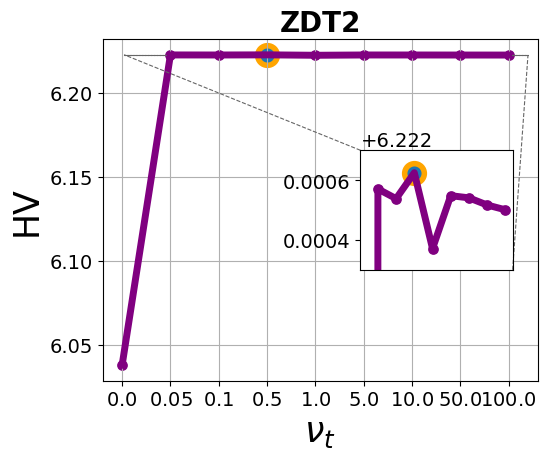

In [53]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="zdt2", colors=colors, 
                             plot_data="hv")

/tmp/ipykernel_471905/3956450853.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


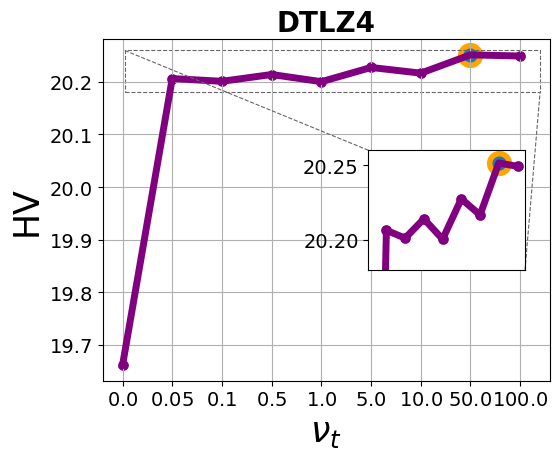

In [54]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="dtlz4", colors=colors, 
                             plot_data="hv")

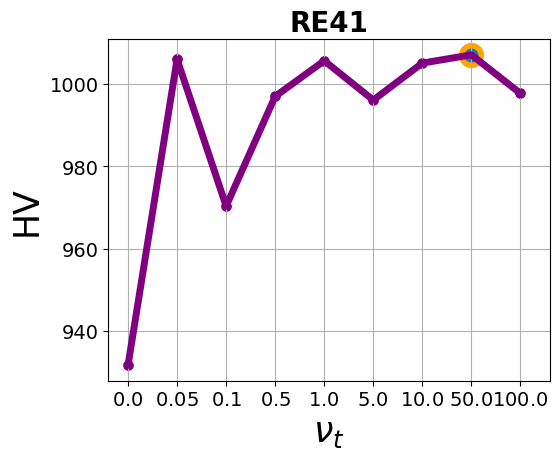

In [55]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="re41", colors=colors, 
                             plot_data="hv")

/tmp/ipykernel_471905/3956450853.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


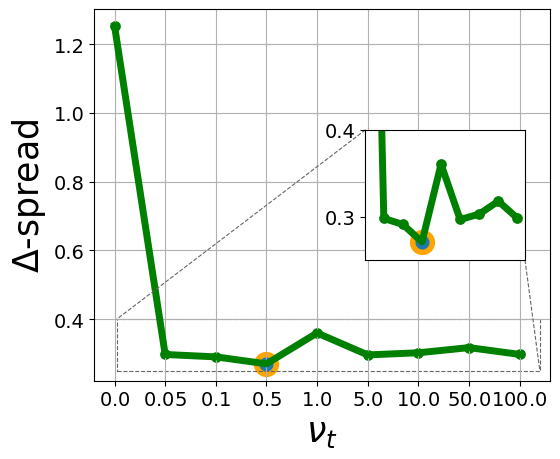

In [56]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="zdt2", colors=colors, 
                             plot_data="diversity")

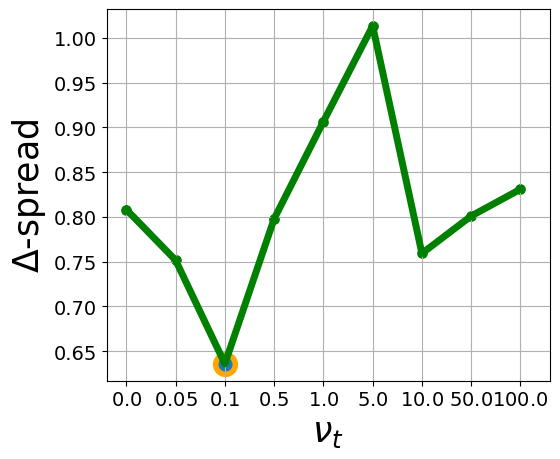

In [59]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="dtlz4", colors=colors, 
                             plot_data="diversity")

/tmp/ipykernel_471905/3956450853.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


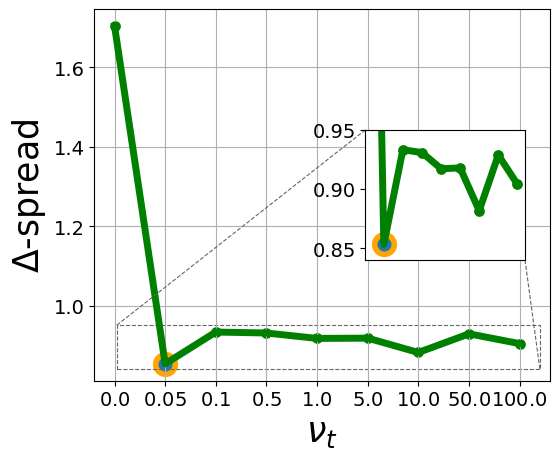

In [60]:
ablation_lambda_rep(list_lambda_rep=[0.0, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                             problem="re41", colors=colors, 
                             plot_data="diversity")

In [61]:

def ablation_noise_scale(list_rho,
                             problem="dtlz4", colors=None, 
                             plot_data="time"):

    seed = 1000
    timesteps = 5000
    nsample = 200
    dict_data = {}

    method = "spread_ablation_rho"
    list_data = []
    for rho in list_rho:
        label = f"rho_{rho}"
        name = (
                method
                + "_"
                + problem
                + "_"
                + str(seed)
                + "_"
                + f"T={timesteps}"
                + "_"
                + f"N={nsample}"
            )
        name += f"_{label}"
            
        res_dir = f"saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
        model_dir = f"log_ms/{method}/saved_{problem}_T{timesteps}_B500" 
        TRAIN_FILE = str("%s/train_infos.pth" % (model_dir))
        TRAIN_FILE = torch.load(TRAIN_FILE, weights_only=False)
        data_dir = f"generated_samples_ms/{method}/"

        with open(res_dir, "rb") as f:
            hv_results = pickle.load(f)
            
        if "hv" in plot_data:
            plt_data = "hypervolume"
        elif "diversity" in plot_data:
            plt_data = "diversity"
        else:
            raise ValueError(f"Unknown plot_data: {plot_data}")

        if "hv" in plot_data:
            total_data = hv_results.get(plt_data, None)
            assert total_data is not None, f"{plt_data} was not saved for method {method} on problem {problem} !"
        else:
            res_y = np.load(data_dir + name + "_y.npy")
            pareto_front = get_pareto_front(problem)
            total_data = delta_spread(res_y, true_pf=pareto_front)
                
        if "time" in plot_data:
            if "spread" in method:
                total_data = total_data + TRAIN_FILE.get("train_time", None)
            total_data = total_data / 60 # convert to minutes
            list_data.append(total_data)
        else:
            list_data.append(total_data)
    dict_data[method] = list_data

    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(list_rho))
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(list_methods)
    

    for i, (method, data) in enumerate(dict_data.items()):
        
        if "hv" in plot_data:
            color = "red"
        else:
            color = "blue"

        ax.plot(x, data, 
                linestyle='-', color=color, 
                linewidth=5) 
        ax.scatter(x, data, s=45, color=color)
        
        # Find index (or indices) of the lowest y value
        x = np.asarray(x)
        data = np.asarray(data)
        if "hv" in plot_data:
            val = np.max(data)
        else:
            val = np.min(data)
        val_idx = np.where(data == val)[0]

        # Overlay hollow circles around them
        ax.scatter(x[val_idx], data[val_idx],
                s=200,              # bigger marker size
                edgecolors="green",   # circle color
                linewidths=4)

            
    if "hv" in plot_data:
        ax.set_ylabel("HV", fontsize=25)
        ax.set_title(problem.upper(), fontweight="bold")
    else:
        ax.set_ylabel("$\Delta$-spread", fontsize=25)
    ax.set_xlabel(r"$\rho$", fontsize=25)

    ax.set_xticks(x)
    xlabels = [f"${n}$" for n in list_rho]
    ax.set_xticklabels(xlabels)
    ax.set_xlim(-0.4, len(xlabels) - 0.4)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    
    ax.grid()
    plt.tight_layout()
    plt.savefig(
        f"plots/exp_stand_{plot_data}_{problem}_rho.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_{plot_data}_{problem}_rho.pdf", format="pdf", bbox_inches="tight")
    plt.show()

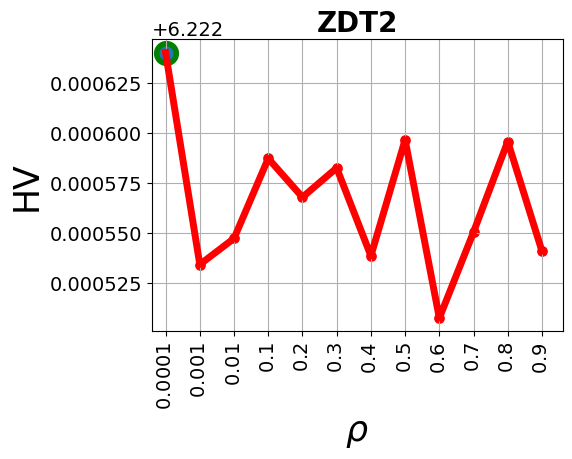

In [62]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="zdt2", colors=colors, 
                             plot_data="hv")

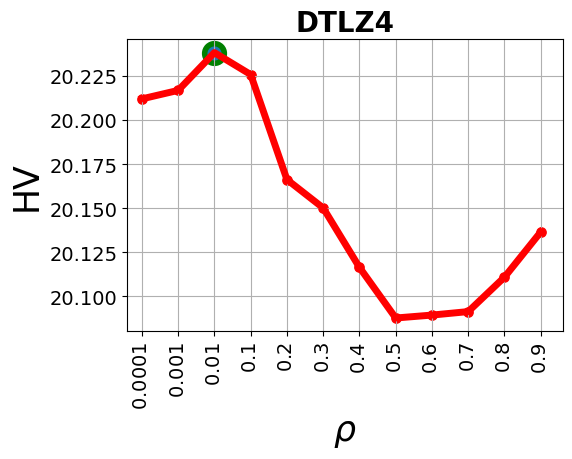

In [63]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="dtlz4", colors=colors, 
                             plot_data="hv")

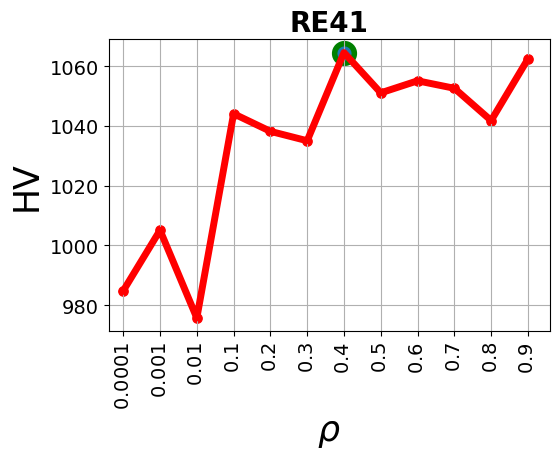

In [64]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="re41", colors=colors, 
                             plot_data="hv")

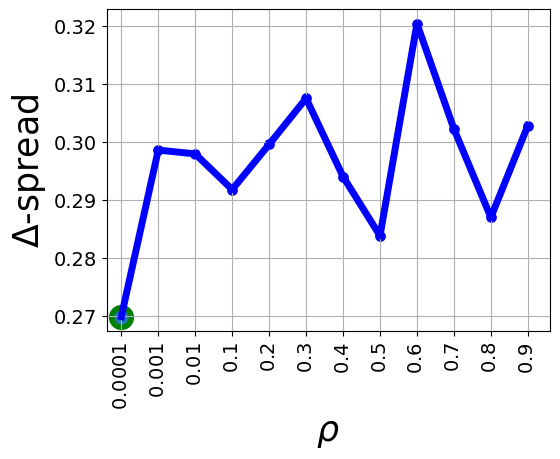

In [65]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="zdt2", colors=colors, 
                             plot_data="diversity")

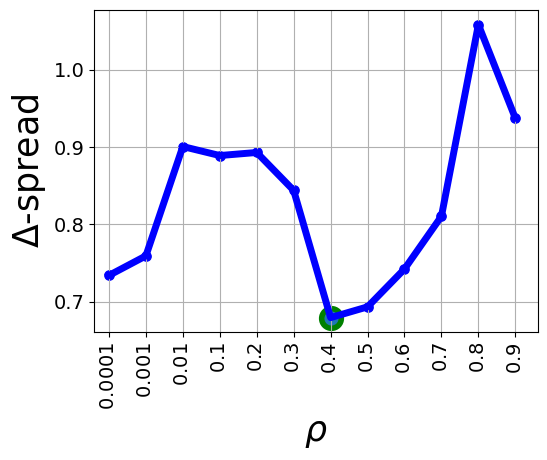

In [66]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="dtlz4", colors=colors, 
                             plot_data="diversity")

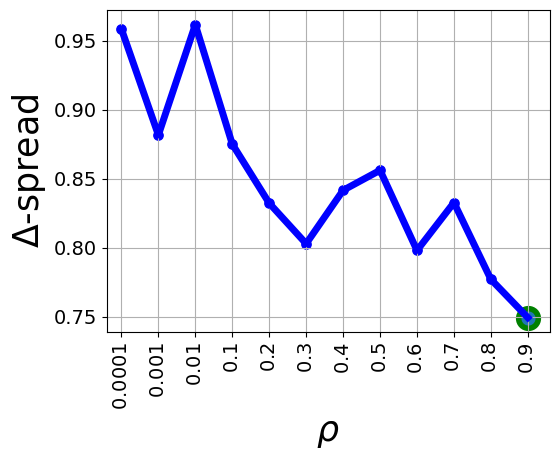

In [67]:
ablation_noise_scale(list_rho=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                             problem="re41", colors=colors, 
                             plot_data="diversity")

In [68]:
def ablation_numBlocks(list_blocks,
                             problem="dtlz4", colors=None, 
                             plot_data="time"):

    seed = 1000
    timesteps = 5000
    nsample = 200
    dict_data = {}

    for b in list_blocks:
        method = f"spread_ablation_ditblocks_Block{b}"
        name = (
                method
                + "_"
                + problem
                + "_"
                + str(seed)
                + "_"
                + f"T={timesteps}"
                + "_"
                + f"N={nsample}"
        )
            
        res_dir = f"saved_metrics_ms/{method}/" + name + "_hv_results.pkl"
        model_dir = f"log_ms/{method}/saved_{problem}_T{timesteps}_B500" 
        TRAIN_FILE = str("%s/train_infos.pth" % (model_dir))
        TRAIN_FILE = torch.load(TRAIN_FILE, weights_only=False)
        data_dir = f"generated_samples_ms/{method}/"
        
        with open(res_dir, "rb") as f:
            hv_results = pickle.load(f)
            
        if "hv" in plot_data:
            plt_data = "hypervolume"
        elif "diversity" in plot_data:
            plt_data = "diversity"
        else:
            raise ValueError(f"Unknown plot_data: {plot_data}")

        if "hv" in plot_data:
            total_data = hv_results.get(plt_data, None)
            assert total_data is not None, f"{plt_data} was not saved for method {method} on problem {problem} !"
        else:
            res_y = np.load(data_dir + name + "_y.npy")
            pareto_front = get_pareto_front(problem)
            total_data = delta_spread(res_y, true_pf=pareto_front)
                
        dict_data[str(b)] = total_data
        
    print(dict_data)

    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(list_blocks))
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * len(list_methods)

    # Extract and sort by key
    labels, values = zip(*sorted(dict_data.items(), key=lambda x: float(x[0])))
    
    x = np.array([float(l) for l in labels])
    y = np.array(values)
    ax.scatter(x, y, c=colors[0:len(labels)], s=350, edgecolor="black", zorder=3)
    # Line plot (black line connecting them)
    ax.plot(x, y, color="black", linewidth=1.5, zorder=2)
    
    if "hv" in plot_data:
        val = np.max(y)
    else:
        val = np.min(y)
    val_idx = np.where(y == val)[0]
    # Overlay hollow circles around them
    ax.scatter(x[val_idx], y[val_idx],
                s=600,              # bigger marker size
                facecolors="none",  # hollow
                edgecolors=colors[len(labels)],   # circle color
                linewidths=4)

    # ax.set_xlabel("Sampling Step")
    if "hv" in plot_data:
        ax.set_ylabel("HV", fontsize=25)
        ax.set_title(problem.upper(), fontweight="bold")
    else:
        ax.set_ylabel("$\Delta$-spread", fontsize=25)

    ax.set_xlabel("$L$", fontsize=25)

    ax.set_xticks(x)
    xlabels = [f"${n}$" for n in list_blocks]
    ax.set_xticklabels(xlabels)
            
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    ax.grid()
    plt.tight_layout()
    plt.savefig(
        f"plots/exp_stand_{plot_data}_{problem}_blocks.jpg", 
        dpi=300,            
        format="jpeg",     
        bbox_inches="tight" 
    )
    plt.savefig(f"plots/exp_stand_{plot_data}_{problem}_blocks.pdf", format="pdf", bbox_inches="tight")
    plt.show()

{'1': 6.22255619820611, '2': 6.2226161928704204, '3': 6.222540791994271, '4': 6.222495182951079, '5': 6.222546128144096}


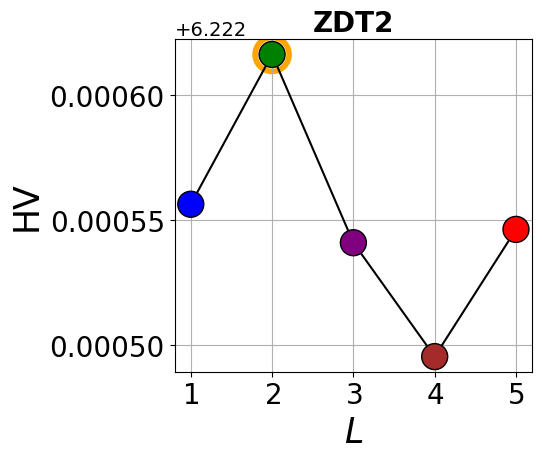

In [69]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="zdt2",
              colors = colors, plot_data="hv")

{'1': 20.204696959322494, '2': 20.228997291657347, '3': 20.216717590081238, '4': 20.2334081405198, '5': 20.224736672039647}


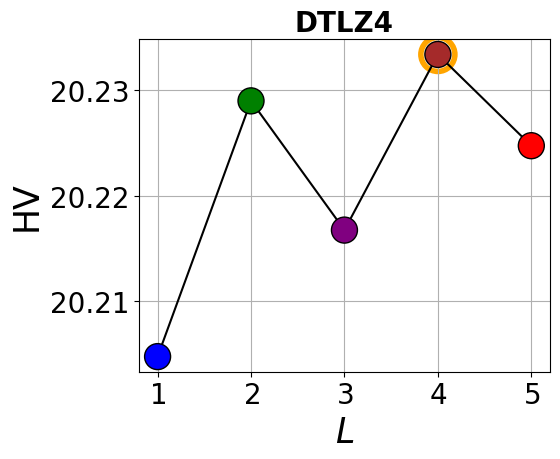

In [70]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="dtlz4",
              colors = colors, plot_data="hv")

{'1': 981.5406207406982, '2': 1010.6712548790181, '3': 1005.081913204016, '4': 1002.8719534023552, '5': 1001.1070989738351}


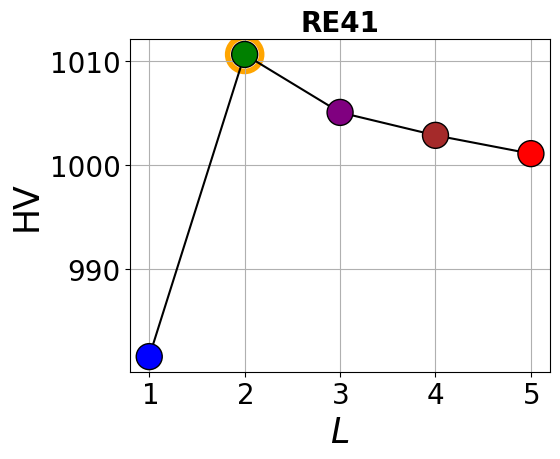

In [71]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="re41",
              colors = colors, plot_data="hv")

{'1': 0.3037296833000372, '2': 0.28714753603349613, '3': 0.30278850928387124, '4': 0.30380307891777447, '5': 0.31239708254504867}


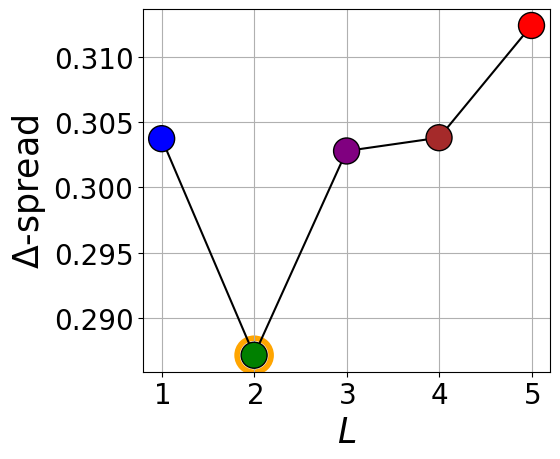

In [72]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="zdt2",
              colors = colors, plot_data="diversity")

{'1': 0.9643119567499007, '2': 0.7571213463696512, '3': 0.7592024276385873, '4': 0.8098456730865008, '5': 0.8764771831784829}


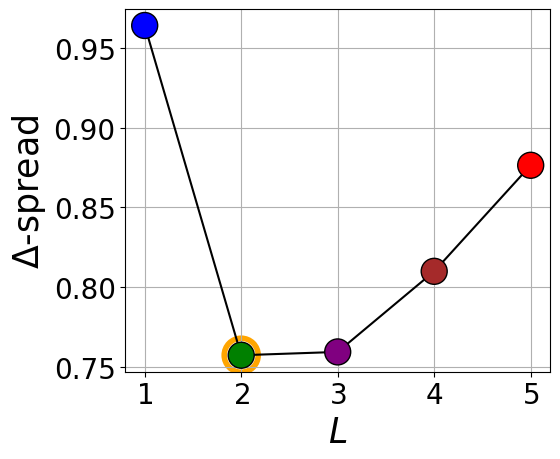

In [73]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="dtlz4",
              colors = colors, plot_data="diversity")

{'1': 0.913564863393318, '2': 0.9277158804170866, '3': 0.881655714649649, '4': 0.9019034327998816, '5': 0.9455969928878664}


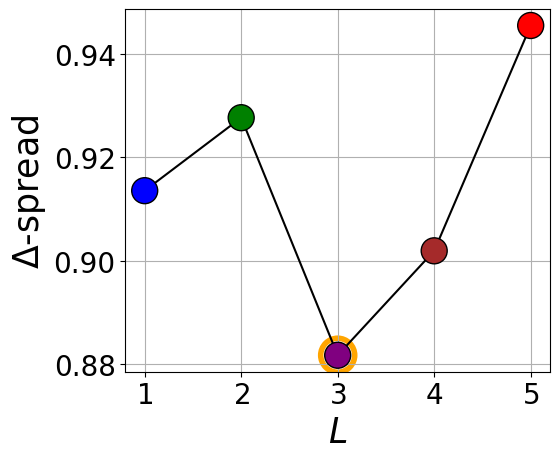

In [74]:
ablation_numBlocks(
              list_blocks = [1, 2, 3, 4, 5],
              problem="re41",
              colors = colors, plot_data="diversity")